In [436]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from math import sqrt

# Preprocessing
from sklearn.preprocessing import OneHotEncoder

# Model selection
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Linear Models
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

# Ensemble models
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor


# Evaluation metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Feature selection
from sklearn.feature_selection import RFECV

# Read data set 1: Taux_de_motorisation_a_lIRIS

In [358]:
car_rate_data = pd.read_excel('Taux_de_motorisation_a_lIRIS-Global_Map_Solution.xlsx')

In [117]:
def overview_features(df):
    """
    Returns the ratio of nulls values, type and cardinality of each feature"""
    columns = df.columns
    types = df.dtypes.values
    cardinality = df.nunique().values
    nulls = df.isnull().sum()
    nulls_ratio = ((df.isnull().sum() / len(df)).values * 100).round(2)

    df_desc = pd.DataFrame({'Feat'       : columns, 
                            'Nulls'      : nulls,
                            'Nulls (%)'  : nulls_ratio, 
                            'Type'       : types, 
                            'Cardinality': cardinality}).set_index('Feat').sort_values(by='Cardinality')
    df_desc.Type.value_counts()
    
    return df_desc


def count_types_features(df):
    return df.dtypes.value_counts()


In [14]:
print('Car ownership (“taux de motorisation”) at the IRIS level\nShape: {}'.format(car_rate_data.shape))
car_rate_data.head()

Car ownership (“taux de motorisation”) at the IRIS level
Shape: (50153, 7)


Code IRIS                                           Nom IRIS Code Commune  \
0  010010000                            L'Abergement-Clémenciat        01001   
1  010020000                              L'Abergement-de-Varey        01002   
2  010040101  Ambérieu-en-Bugey / Les Perouses-Triangle d'Ac...        01004   
3  010040102                  Ambérieu-en-Bugey / Longeray-Gare        01004   
4  010040201    Ambérieu-en-Bugey / Centre-St Germain-Vareilles        01004   

               Nom Commune  Taux de motorisation IRIS  \
0  L'Abergement-Clémenciat                   0.963576   
1    L'Abergement-de-Varey                   0.950495   
2        Ambérieu-en-Bugey                   0.781567   
3        Ambérieu-en-Bugey                   0.816198   
4        Ambérieu-en-Bugey                   0.816397   

   Taux de motorisation Commune  Taux de motorisation Département  
0                      0.963576                          0.903721  
1                      0.950495                          0.903721  
2                      0.854474                          0.903721  
3                      0.854474                          0.903721  
4                      0.854474                          0.903721

In [103]:
count_types_features(car_rate_data)

object     3
float64    3
dtype: int64

In [359]:
overview_features(car_rate_data)

Nulls  Nulls (%)     Type  Cardinality
Feat                                                                    
Taux de motorisation Département      0       0.00  float64           96
Taux de motorisation Commune          6       0.01  float64        12617
Taux de motorisation IRIS           173       0.34  float64        25057
Nom Commune                           0       0.00   object        34066
Code Commune                          0       0.00   object        36571
Nom IRIS                              0       0.00   object        47750
Code IRIS                             0       0.00   object        50153

> **Observation 1**: Very few data are missing. Let see if we can complete them using other rows from the data set

> **Observation 2**: Number of unique 'Nom Commune' is lower than the number of unique 'Code Commune'

In [78]:
test_1 = car_rate_data[['Nom Commune', 'Code Commune']].drop_duplicates()
multiple_communes_names = test_1['Nom Commune'].value_counts().to_frame().reset_index()
multiple_communes_names_list = multiple_communes_names[multiple_communes_names['Nom Commune'] > 1]['index'].values
test_1[test_1['Nom Commune'].isin(multiple_communes_names_list)].sort_values(by='Nom Commune')

Nom Commune Code Commune
28756   Abancourt        59001
30103   Abancourt        60001
25863   Aboncourt        54003
27482   Aboncourt        57001
15903       Abzac        33001
...           ...          ...
8243      Étréchy        18090
772     Étrépilly        02297
41435   Étrépilly        77173
47497        Évry        91228
46876        Évry        89162

[4103 rows x 2 columns]

> I can use the 'Nom Commune' to fill the missing 'Taux de motorisation Commune' values. But I won't since I am not sure that there is or not a spelling mistake

In [80]:
car_rate_data[car_rate_data['Nom Commune'] == 'Évry']

Code IRIS                            Nom IRIS Code Commune Nom Commune  \
46876  891620000                                Évry        89162        Évry   
47497  912280101  Évry / Bois Guillaume-Bois Sauvage        91228        Évry   
47498  912280102                        Évry / Loges        91228        Évry   
47499  912280103             Évry / Pyramides Centre        91228        Évry   
47500  912280104                Évry / Pyramides Sud        91228        Évry   
47501  912280105           Évry / Centre urbain Nord        91228        Évry   
47502  912280106       Évry / Centre urbain Coquibus        91228        Évry   
47503  912280107               Évry / Aunettes Ouest        91228        Évry   
47504  912280108                 Évry / Aunettes Est        91228        Évry   
47505  912280109              Évry / Epinettes Ouest        91228        Évry   
47506  912280110                Évry / Epinettes Est        91228        Évry   
47507  912280111                Évry / Epinettes Sud        91228        Évry   
47508  912280112        Évry / Bras de Fer-Tourelles        91228        Évry   
47509  912280113             Évry / Parc aux Lievres        91228        Évry   
47510  912280114  Évry / Mousseau-Bonhomme en Pierre        91228        Évry   
47511  912280115                       Évry / Aguado        91228        Évry   
47512  912280116                      Évry / Village        91228        Évry   
47513  912280117             Évry / Champtier du Coq        91228        Évry   
47514  912280118                  Évry / Grand Bourg        91228        Évry   
47515  912280119               Évry / Champs Elysees        91228        Évry   
47516  912280120    Évry / Centre commercial EVRY II        91228        Évry   
47517  912280121         Évry / Centre administratif        91228        Évry   
47518  912280122                       Évry / Snecma        91228        Évry   

       Taux de motorisation IRIS  Taux de motorisation Commune  \
46876                   0.945578                      0.945578   
47497                   0.741498                      0.714569   
47498                   0.601809                      0.714569   
47499                   0.566708                      0.714569   
47500                   0.538378                      0.714569   
47501                   0.568109                      0.714569   
47502                   0.587585                      0.714569   
47503                   0.750337                      0.714569   
47504                   0.835530                      0.714569   
47505                   0.817150                      0.714569   
47506                   0.704443                      0.714569   
47507                   0.664766                      0.714569   
47508                   0.867207                      0.714569   
47509                   0.656911                      0.714569   
47510                   0.827227                      0.714569   
47511                   0.817994                      0.714569   
47512                   0.807693                      0.714569   
47513                   0.698686                      0.714569   
47514                   0.849443                      0.714569   
47515                   0.810008                      0.714569   
47516                   0.673797                      0.714569   
47517                   1.000000                      0.714569   
47518                   0.733333                      0.714569   

       Taux de motorisation Département  
46876                          0.855093  
47497                          0.842058  
47498                          0.842058  
47499                          0.842058  
47500                          0.842058  
47501                          0.842058  
47502                          0.842058  
47503                          0.842058  
47504                          0.842058  
47505                          0.842058  
47506          

> in fact we can not do that as we see in this example. The two rates are far from each other. 

> For the rest of the exercise I will only refer to 'Code Commune'

In [81]:
car_rate_data.drop('Nom Commune', axis=1, inplace=True)

## Municipalities with missing 'car equipment rate'

In [114]:
missing_muni_car_rate = car_rate_data[car_rate_data['Taux de motorisation Commune'].isnull()]

count = 0
for commune in missing_muni_car_rate['Code Commune'].values:
    if len(car_rate_data[car_rate_data['Code Commune'] == commune]) > 1:
        print('wa can recover the rate')
        print(car_rate_data[car_rate_data['Code Commune'] == commune])
        count += 1

print('{} missing values can be recovered easily from the data set'.format(count))

0 missing values can be recovered easily from the data set


> No missing 'Taux de motorisation Commune' that we can recover easily. 

### Unique (municipality, car rate)

In [17]:
unique_municipality_car_rate = car_rate_data[['Code Commune', 'Taux de motorisation Commune']].drop_duplicates()
print(car_rate_data.shape)
print(unique_municipality_car_rate.drop_duplicates().shape)
print(unique_municipality_car_rate[['Code Commune', 'Taux de motorisation Commune']].nunique())

(50153, 7)
(36571, 2)
Code Commune                    36571
Taux de motorisation Commune    12617
dtype: int64


> No municipality has different values of 'Taux de motorisation Commune'

# Read data set 2: Data INSEE sur les communes

In [18]:
communes_data = pd.read_excel('MDB-INSEE-V2.xls')

WARNING *** file size (57125979) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [20]:
print('Socioeconomic and demographic data at the municipality level\nShape: {}'.format(communes_data.shape))
communes_data.head(3)

Socioeconomic and demographic data at the municipality level
Shape: (36677, 101)


CODGEO  Nb Pharmacies et parfumerie  Dynamique Entrepreneuriale  \
0  01001                          0.0                        57.0   
1  01002                          0.0                        45.0   
2  01004                          0.0                       634.0   

   Dynamique Entrepreneuriale Service et Commerce  Synergie Médicale COMMUNE  \
0                                            23.0                        114   
1                                             4.0                        143   
2                                           828.0                        366   

  Orientation Economique  Indice Fiscal Partiel  Score Fiscal  \
0      Bassin Industriel              101.93878      59.04139   
1     Bassin Résidentiel              101.93878      59.04139   
2     Bassin Résidentiel              101.93878      59.04139   

   Indice Evasion Client  Score Evasion Client  Indice Synergie Médicale  \
0                0.00000               0.00000                 114.56713   
1                0.00000               0.00000                 143.71141   
2              248.45549               0.10621                 367.82080   

   Score Synergie Médicale           SEG Croissance POP  \
0                  0.13481  en croissance démographique   
1                  0.17351  en croissance démographique   
2                  0.47115  en croissance démographique   

                     LIBGEO  REG DEP  Nb Omnipraticiens BV  \
0  L' Abergement-Clémenciat   82  01                     9   
1    L' Abergement-de-Varey   82  01                    31   
2         Ambérieu-en-Bugey   82  01                    31   

   Nb Infirmiers Libéraux BV  Nb dentistes Libéraux BV  \
0                         14                         7   
1                         36                        18   
2                         36                        18   

   Nb pharmaciens Libéraux BV  Densité Médicale BV  \
0                           7             0.092860   
1                          18             0.099229   
2                          18             0.099229   

   Score équipement de santé BV  Indice Démographique  Score Démographique  \
0                             4              44.19769              0.03410   
1                             4              10.18071              0.00786   
2                             4             696.92134              0.53776   

   Indice Ménages  Score Ménages  Population  Evolution Population  \
0        37.22029        0.02223         725                    16   
1        10.09619        0.00603         167                     4   
2       699.19896        0.41767       11432                   512   

   Evolution Pop %  Nb Ménages  Nb Résidences Principales  Nb propriétaire  \
0                2         247                        248              196   
1                2          67                         67               61   
2                4        4640                       4635             1968   

   Nb Logement  Nb Résidences Secondaires  Nb Log Vacants  \
0          289                         32               9   
1          142                         71               4   
2         5184                        135             414   

   Nb Occupants Résidence Principale  Nb Femme  Nb Homme  Nb Mineurs  \
0                                728       694       714         909   
1                                168       162       164         202   
2                              11015     11350     10878       13624   

   Nb Majeurs  Nb Etudiants  Nb Entreprises Secteur Services  \
0         499            51                              7.0   
1         124             5                              4.0   
2        8604           904                            342.0   

   Nb Entreprises Secteur Commerce  Nb Entreprises Secteur Construction  \
0                             11.0                                  2.0   
1                              0.0                    

> Same for the first data set I will remove 'LIBGEO'

In [376]:
communes_data.drop('LIBGEO', axis=1, inplace=True)

In [106]:
count_types_features(communes_data)

float64    51
int64      35
object     14
dtype: int64

In [119]:
# Features overview
overview_features(communes_data)

Nulls  Nulls (%)     Type  \
Feat                                                                            
Fidélité                                                0       0.00   object   
SEG Croissance POP                                      0       0.00   object   
DYN SetC                                                1       0.00   object   
Seg Dyn Entre                                           1       0.00   object   
Seg Cap Fiscale                                         0       0.00   object   
SYN MEDICAL                                             0       0.00   object   
Score équipement de santé BV                            0       0.00    int64   
Orientation Economique                                  0       0.00   object   
Urbanité Ruralité                                       0       0.00   object   
Dynamique Démographique BV                              0       0.00   object   
Environnement Démographique                             0       0.00   object   
SEG Environnement Démographique Obsolète                0       0.00   object   
Score Urbanité                                          0       0.00  float64   
Taux étudiants                                          0       0.00    int64   
Score PIB                                               0       0.00  float64   
PIB Régionnal                                           0       0.00    int64   
Nb Industries des biens intermédiaires                  0       0.00    int64   
Nb de Commerce                                          0       0.00    int64   
Valeur ajoutée régionale                                0       0.00  float64   
Nb institution de Education, santé, action soci...      0       0.00    int64   
Nb de Services aux particuliers                         0       0.00    int64   
Moyenne Revenus Fiscaux Régionaux                       0       0.00    int64   
Score VA Région                                         0       0.00  float64   
Nb Pharmacies et parfumerie                             1       0.00  float64   
Indice Fiscal Partiel                                   0       0.00  float64   
Score Fiscal                                            0       0.00  float64   
REG                                                     0       0.00    int64   
Reg Moyenne Salaires Horaires                           0       0.00  float64   
Reg Moyenne Salaires Cadre Horaires                     0       0.00  float64   
Reg Moyenne Salaires Prof Intermédiaire Horaires        0       0.00  float64   
Reg Moyenne Salaires Employé Horaires                   0       0.00  float64   
Reg Moyenne Salaires Ouvrié Horaires                    0       0.00  float64   
Nb Camping                                            112       0.31  float64   
Nb pharmaciens Libéraux BV                              0       0.00    int64   
Nb dentistes Libéraux BV                                0       0.00    int64   
Nb Création Industrielles                               1       0.00  float64   
Nb Hotel                                              112       0.31  float64   
Nb Omnipraticiens BV                                    0       0.00    int64   
Nb Infirmiers Libéraux BV                               0       0.00    int64   
Evolution Pop %                                         0       0.00    int64   
Score Croissance Population                             0       0.00  float64   
Indice Evasion Client                                   0       0.00  float64   
Score Evasion Client                                    0       0.00  float64   
Taux Evasion Client                                     0       0.00    int64   
Moyenne Revnus fiscaux                                  0       0.00  float64   
Taux Propriété                                          0       0.00    int64   
Moyenne Revenus Fiscaux Départementaux                  0       0.00    int64   
Dep Moyenne Salaires Ouvrié Horaires                    0       0.00  float64   
De

> **Observation 1**: Out of 36K observations, the maximum cardinality is 5K

> **Observation 2**: First observation: More municipalities in this data set than the first one. 36677 compared to 36571 (106)

> **Observation 3**: Number of missing values very low (max 0.34%), can be ignored for a first time

In [121]:
communes_data_rows_nan_count = len(communes_data) - len(communes_data.dropna())
print('Number of rows with NaN: {} ({} %)'.format(communes_data_rows_nan_count,
                                                  round(communes_data_rows_nan_count/len(communes_data) * 100, 2)))

Number of rows with NaN: 127 (0.35 %)


> Before removing them we should see if they belong to useful features or if they can be recovered from correlated columns. But for a constraint of time let us remove them

In [122]:
communes_data.dropna(inplace=True)

In [123]:
print("{} municipalities are in dataset 2 and not in dataset 1".format(len(set(communes_data['CODGEO']) - set(car_rate_data['Code Commune']))))
print("{} municipalities are in dataset 1 and not in dataset 2".format(len(set(car_rate_data['Code Commune']) - set(communes_data['CODGEO']))))

      

51 municipalities are in dataset 2 and not in dataset 1
72 municipalities are in dataset 1 and not in dataset 2


## Join two dataframes

> Check for how many municipalities we do not obtain 'Taux de motorisation Commune'. We use here unique_municipality_car_rate not to have duplicate rows

In [124]:
merged_data = pd.merge(communes_data, unique_municipality_car_rate, how='left', 
                       left_on='CODGEO', right_on='Code Commune', sort=False).drop(['Code Commune'], axis=1)

In [125]:
merged_data.head(1)

CODGEO  Nb Pharmacies et parfumerie  Dynamique Entrepreneuriale  \
0  01001                          0.0                        57.0   

   Dynamique Entrepreneuriale Service et Commerce  Synergie Médicale COMMUNE  \
0                                            23.0                        114   

  Orientation Economique  Indice Fiscal Partiel  Score Fiscal  \
0      Bassin Industriel              101.93878      59.04139   

   Indice Evasion Client  Score Evasion Client  Indice Synergie Médicale  \
0                    0.0                   0.0                 114.56713   

   Score Synergie Médicale           SEG Croissance POP  REG DEP  \
0                  0.13481  en croissance démographique   82  01   

   Nb Omnipraticiens BV  Nb Infirmiers Libéraux BV  Nb dentistes Libéraux BV  \
0                     9                         14                         7   

   Nb pharmaciens Libéraux BV  Densité Médicale BV  \
0                           7              0.09286   

   Score équipement de santé BV  Indice Démographique  Score Démographique  \
0                             4              44.19769               0.0341   

   Indice Ménages  Score Ménages  Population  Evolution Population  \
0        37.22029        0.02223         725                    16   

   Evolution Pop %  Nb Ménages  Nb Résidences Principales  Nb propriétaire  \
0                2         247                        248              196   

   Nb Logement  Nb Résidences Secondaires  Nb Log Vacants  \
0          289                         32               9   

   Nb Occupants Résidence Principale  Nb Femme  Nb Homme  Nb Mineurs  \
0                                728       694       714         909   

   Nb Majeurs  Nb Etudiants  Nb Entreprises Secteur Services  \
0         499            51                              7.0   

   Nb Entreprises Secteur Commerce  Nb Entreprises Secteur Construction  \
0                             11.0                                  2.0   

   Nb Entreprises Secteur Industrie  Nb Création Enteprises  \
0                               2.0                     4.0   

   Nb Création Industrielles  Nb Création Construction  Nb Création Commerces  \
0                        0.0                       2.0                    1.0   

   Nb Création Services  Moyenne Revenus Fiscaux Départementaux  \
0                   1.0                                   12509   

   Moyenne Revenus Fiscaux Régionaux  Dep Moyenne Salaires Horaires  \
0                              10458                      11.410345   

   Dep Moyenne Salaires Cadre Horaires  \
0                            21.963793   

   Dep Moyenne Salaires Prof Intermédiaire Horaires  \
0                                         12.558621   

   Dep Moyenne Salaires Employé Horaires  \
0                               8.743103   

   Dep Moyenne Salaires Ouvrié Horaires  Reg Moyenne Salaires Horaires  \
0                              9.268966                      11.873022   

   Reg Moyenne Salaires Cadre Horaires  \
0                             21.78783   

   Reg Moyenne Salaires Prof Intermédiaire Horaires  \
0                                         12.704057   

   Reg Moyenne Salaires Employé Horaires  \
0                               8.783164   

   Reg Moyenne Salaires Ouvrié Horaires  Valeur ajoutée régionale  \
0                               9.30142              86957.458359   

            Urbanité Ruralité  Score Urbanité  Nb Atifs  Nb Actifs Salariés  \
0  Com rurale < 2 000 m habts             0.0     295.0               254.0   

   Nb Actifs Non Salariés  Nb Logement Secondaire et Occasionnel  Nb Hotel  \
0                    41.0                                   32.0       0.0   

   Capacité Hotel  Nb Camping  Capacité Camping  \
0             0.0         0.0               0.0   

                          Dynamique Démographique BV  Taux étudiants  \
0  1.Accroissement par excédent naturel et migrat...               0   

   Taux Propriété 

In [126]:
print('original data shape:', communes_data.shape)
print('merged data shape  :', merged_data.shape)

original data shape: (36550, 100)
merged data shape  : (36550, 101)


In [127]:
missing_count = merged_data['Taux de motorisation Commune'].isnull().sum()
missing_rate = round(missing_count / len(merged_data) * 100, 2)
print("Missing car rate for: {} ({} %) municipalities".format(missing_count, missing_rate))

Missing car rate for: 57 (0.16 %) municipalities


In [128]:
overview_features(merged_data)

Nulls  Nulls (%)     Type  \
Feat                                                                            
SEG Croissance POP                                      0       0.00   object   
Fidélité                                                0       0.00   object   
DYN SetC                                                0       0.00   object   
Seg Dyn Entre                                           0       0.00   object   
Seg Cap Fiscale                                         0       0.00   object   
SYN MEDICAL                                             0       0.00   object   
Orientation Economique                                  0       0.00   object   
Score équipement de santé BV                            0       0.00    int64   
Urbanité Ruralité                                       0       0.00   object   
Environnement Démographique                             0       0.00   object   
Dynamique Démographique BV                              0       0.00   object   
SEG Environnement Démographique Obsolète                0       0.00   object   
Score Urbanité                                          0       0.00  float64   
Reg Moyenne Salaires Cadre Horaires                     0       0.00  float64   
Reg Moyenne Salaires Prof Intermédiaire Horaires        0       0.00  float64   
Reg Moyenne Salaires Employé Horaires                   0       0.00  float64   
Reg Moyenne Salaires Ouvrié Horaires                    0       0.00  float64   
Valeur ajoutée régionale                                0       0.00  float64   
Taux étudiants                                          0       0.00    int64   
Reg Moyenne Salaires Horaires                           0       0.00  float64   
Nb de Services aux particuliers                         0       0.00    int64   
Nb institution de Education, santé, action soci...      0       0.00    int64   
PIB Régionnal                                           0       0.00    int64   
Score VA Région                                         0       0.00  float64   
Score PIB                                               0       0.00  float64   
Nb Industries des biens intermédiaires                  0       0.00    int64   
Nb de Commerce                                          0       0.00    int64   
Moyenne Revenus Fiscaux Régionaux                       0       0.00    int64   
Indice Fiscal Partiel                                   0       0.00  float64   
Score Fiscal                                            0       0.00  float64   
REG                                                     0       0.00    int64   
Nb Pharmacies et parfumerie                             0       0.00  float64   
Nb Camping                                              0       0.00  float64   
Nb dentistes Libéraux BV                                0       0.00    int64   
Nb pharmaciens Libéraux BV                              0       0.00    int64   
Nb Création Industrielles                               0       0.00  float64   
Nb Hotel                                                0       0.00  float64   
Nb Omnipraticiens BV                                    0       0.00    int64   
Nb Infirmiers Libéraux BV                               0       0.00    int64   
Evolution Pop %                                         0       0.00    int64   
Score Croissance Population                             0       0.00  float64   
Score Evasion Client                                    0       0.00  float64   
Indice Evasion Client                                   0       0.00  float64   
Taux Evasion Client                                     0       0.00    int64   
Moyenne Revnus fiscaux                                  0       0.00  float64   
Dep Moyenne Salaires Ouvrié Horaires                    0       0.00  float64   
Dep Moyenne Salaires Employé Horaires                   0       0.00  float64   
Dep Moyenne Salaires Prof Intermédiaire Horaires        0       0.00  float64   
De

> Here we observe that missing values from dataset 1 (in 'Taux de motorisation Commune') is not impacting the merge

**For the following, we will consider the 57 missing values as test data for which I do not have the target (but maybe you do, or someone does).**

**I have now a data set containing several features (and others that we can recover from the IRIS data set), with no missing values. I want to build a model that predicts using these features the target 'Taux de motorisation Commune'.** 

**The idea of building such a model will allow us to predict the missing values, and perhaps use it for other countries that may have similar features**

In [374]:
merged_data.dropna(inplace=True)

# I. Simple baseline

> A first idea would be to make a model using only car equipment rates we have at the IRIS level. We can for example consider the median value (or the mean) of IRIS area at each municipality. It will give us a first baseline.

> Later we can build models performing better.

In [171]:
iris_grouped = car_rate_data.groupby(['Code Commune'])['Taux de motorisation IRIS', 
                                                       'Taux de motorisation Commune'].agg({
                                                                'Taux de motorisation Commune':['max'],
                                                                'Taux de motorisation IRIS':['mean', 'median']})
iris_grouped = iris_grouped.rename(columns={'mean': 'Taux_Commune_mean', 'median': 
                     'Taux_Commune_median', 'max': 'Taux de motorisation Commune'}).droplevel(0, axis=1).dropna()
iris_grouped.head()

Taux de motorisation Commune  Taux_Commune_mean  \
Code Commune                                                    
01001                             0.963576           0.963576   
01002                             0.950495           0.950495   
01004                             0.854474           0.842288   
01005                             0.954693           0.954693   
01006                             0.886792           0.886792   

              Taux_Commune_median  
Code Commune                       
01001                    0.963576  
01002                    0.950495  
01004                    0.816298  
01005                    0.954693  
01006                    0.886792

In [172]:
print('RMSE of model using the median value at IRIS level: {}'.format(sqrt(mean_squared_error(
    iris_grouped['Taux de motorisation Commune'], iris_grouped['Taux_Commune_median']))))

print('RMSE of model using the mean value at IRIS level: {}\n'.format(sqrt(mean_squared_error(
    iris_grouped['Taux de motorisation Commune'], iris_grouped['Taux_Commune_mean']))))

print('R2 of model using the mean value at IRIS level: {}'.format(r2_score(
    iris_grouped['Taux de motorisation Commune'], iris_grouped['Taux_Commune_median'])))

print('R2 of model using the mean value at IRIS level: {}'.format(r2_score(
    iris_grouped['Taux de motorisation Commune'], iris_grouped['Taux_Commune_mean'])))

RMSE of model using the median value at IRIS level: 0.0051481132500022665
RMSE of model using the mean value at IRIS level: 0.0030136971268874715

R2 of model using the mean value at IRIS level: 0.9911094475970103
R2 of model using the mean value at IRIS level: 0.9969532854256177


> The results are very good, which now I believe is expected, since I guess the value of car equipment rate was computed as a weighted mean of the car equipment rates at IRIS level 

> I guess the idea of such an exercise is to be able to predict the value of the car equipment rate without using car equipment rates at IRIS levels. We will then not use those information.

> Finally we can't consider the previous model as a baseline

# II. Data Analysis

In [173]:
data_set = merged_data.copy()

target = 'Taux de motorisation Commune'


In [176]:
count_types_features(data_set)

float64    52
int64      35
object     14
dtype: int64

In [185]:
data_set_overview_feats = overview_features(data_set)
data_set_overview_feats

Nulls  Nulls (%)     Type  \
Feat                                                                            
SEG Croissance POP                                      0        0.0   object   
Fidélité                                                0        0.0   object   
DYN SetC                                                0        0.0   object   
Seg Dyn Entre                                           0        0.0   object   
Seg Cap Fiscale                                         0        0.0   object   
SYN MEDICAL                                             0        0.0   object   
Orientation Economique                                  0        0.0   object   
Score équipement de santé BV                            0        0.0    int64   
Urbanité Ruralité                                       0        0.0   object   
Environnement Démographique                             0        0.0   object   
Dynamique Démographique BV                              0        0.0   object   
SEG Environnement Démographique Obsolète                0        0.0   object   
Score Urbanité                                          0        0.0  float64   
Taux étudiants                                          0        0.0    int64   
Nb Pharmacies et parfumerie                             0        0.0  float64   
Reg Moyenne Salaires Cadre Horaires                     0        0.0  float64   
Reg Moyenne Salaires Prof Intermédiaire Horaires        0        0.0  float64   
Reg Moyenne Salaires Employé Horaires                   0        0.0  float64   
Reg Moyenne Salaires Ouvrié Horaires                    0        0.0  float64   
Valeur ajoutée régionale                                0        0.0  float64   
Nb Industries des biens intermédiaires                  0        0.0    int64   
Reg Moyenne Salaires Horaires                           0        0.0  float64   
Nb institution de Education, santé, action soci...      0        0.0    int64   
PIB Régionnal                                           0        0.0    int64   
Score VA Région                                         0        0.0  float64   
Score PIB                                               0        0.0  float64   
Nb de Commerce                                          0        0.0    int64   
Nb de Services aux particuliers                         0        0.0    int64   
Moyenne Revenus Fiscaux Régionaux                       0        0.0    int64   
Indice Fiscal Partiel                                   0        0.0  float64   
Score Fiscal                                            0        0.0  float64   
REG                                                     0        0.0    int64   
Nb Camping                                              0        0.0  float64   
Nb pharmaciens Libéraux BV                              0        0.0    int64   
Nb dentistes Libéraux BV                                0        0.0    int64   
Nb Création Industrielles                               0        0.0  float64   
Nb Hotel                                                0        0.0  float64   
Nb Omnipraticiens BV                                    0        0.0    int64   
Nb Infirmiers Libéraux BV                               0        0.0    int64   
Evolution Pop %                                         0        0.0    int64   
Score Croissance Population                             0        0.0  float64   
Taux Evasion Client                                     0        0.0    int64   
Indice Evasion Client                                   0        0.0  float64   
Score Evasion Client                                    0        0.0  float64   
Dep Moyenne Salaires Prof Intermédiaire Horaires        0        0.0  float64   
Dep Moyenne Salaires Employé Horaires                   0        0.0  float64   
Moyenne Revnus fiscaux                                  0        0.0  float64   
Dep Moyenne Salaires Ouvrié Horaires                    0        0.0  float64   
DE

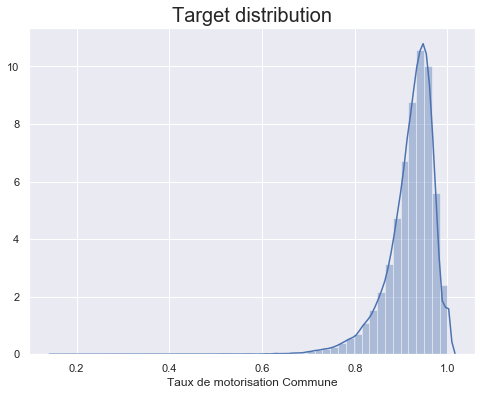

In [337]:
plt.figure(figsize=(8,6))
sns.distplot(data_set[target])
plt.title('Target distribution', fontsize=20)
plt.savefig('Target distribution')

> We observe many outliers, and a normal distribution

> **Idea**: Remove outliers ?

In [373]:
categorical_features = list(data_set_overview_feats[data_set_overview_feats.Type == 'object'].index)
categorical_features.remove('CODGEO')
print('Number of categorical features: {}'.format(len(categorical_features)))

integer_features = list(data_set_overview_feats[data_set_overview_feats.Type == 'int64'].index)
print('Number of integer features    : {}'.format(len(integer_features)))

continuous_features = list(data_set_overview_feats[data_set_overview_feats.Type == 'float64'].index)
print('Number of continuous features : {}'.format(len(continuous_features)))

Number of categorical features: 13
Number of integer features    : 35
Number of continuous features : 52


> Let us observe the behavior of each type of features separatly

## Continuous features

> First thing let see if there is any linear correlation between the target and the continuous features

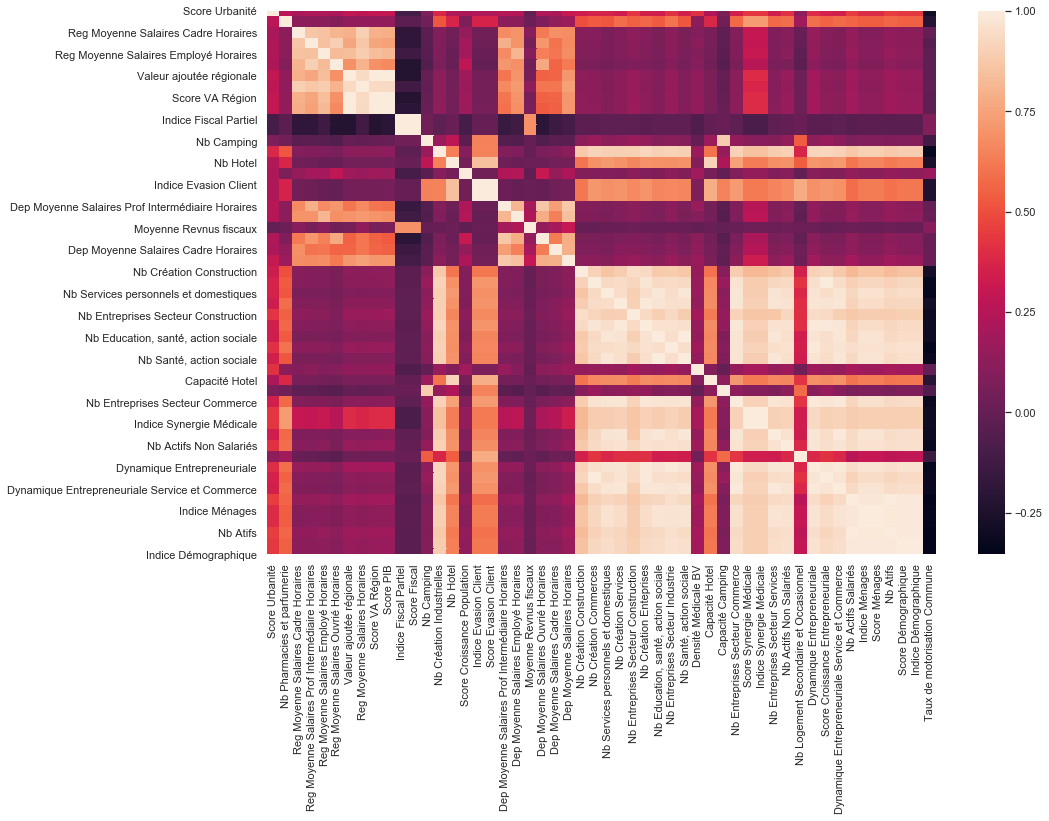

In [341]:
plt.figure(figsize=(15,10))
sns.heatmap(data_set[continuous_features].corr())
plt.savefig('Correlation heatmap')

> **Observation 1**: There is no strong linear correlation between the target and any of the features

> **Observation 2**: However there are features that are correlated and can be removed

In [201]:
def find_correlated_features(df, col, plot=False):
    corr_df = df.corr()
    corr_columns = corr_df[col].sort_values(ascending=True)
    if plot:
        plt.figure(figsize=(25,10))
        corr_columns.plot.bar()
        plt.title("Correlations with {}".format(col), fontsize=20)
        plt.show()
    corr_columns = corr_columns.to_frame(name='Correlation').reset_index().rename(columns={'index': 
                                                                                                   'features'})
    corr_columns['sign'] = np.sign(corr_columns['Correlation'])
    corr_columns['Correlation'] = np.abs(corr_columns['Correlation'])
    return corr_columns.sort_values(by='Correlation', ascending=False)

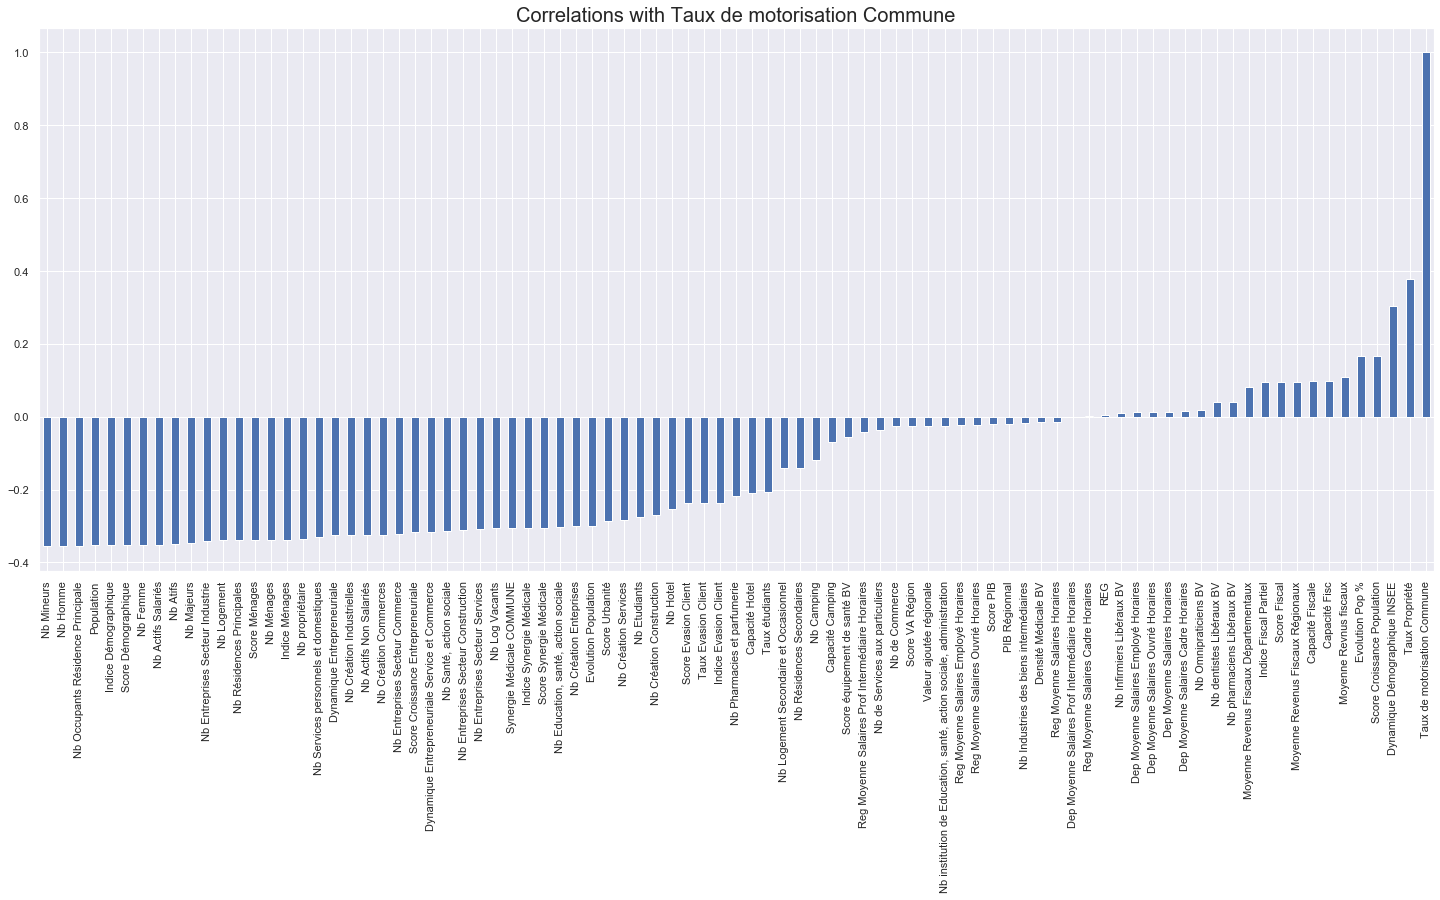

features  Correlation  sign
86                       Taux de motorisation Commune     1.000000   1.0
85                                     Taux Propriété     0.379157   1.0
0                                          Nb Mineurs     0.356172  -1.0
1                                            Nb Homme     0.354947  -1.0
2                   Nb Occupants Résidence Principale     0.354080  -1.0
3                                          Population     0.353461  -1.0
4                                Indice Démographique     0.353461  -1.0
5                                 Score Démographique     0.353461  -1.0
6                                            Nb Femme     0.351028  -1.0
7                                  Nb Actifs Salariés     0.350892  -1.0
8                                            Nb Atifs     0.350019  -1.0
9                                          Nb Majeurs     0.347748  -1.0
10                   Nb Entreprises Secteur Industrie     0.341139  -1.0
11                                        Nb Logement     0.338414  -1.0
12                          Nb Résidences Principales     0.337384  -1.0
13                                      Score Ménages     0.337058  -1.0
14                                         Nb Ménages     0.337058  -1.0
15                                     Indice Ménages     0.337058  -1.0
16                                    Nb propriétaire     0.336829  -1.0
17              Nb Services personnels et domestiques     0.330284  -1.0
18                         Dynamique Entrepreneuriale     0.324639  -1.0
19                          Nb Création Industrielles     0.324513  -1.0
20                             Nb Actifs Non Salariés     0.324462  -1.0
21                              Nb Création Commerces     0.324276  -1.0
22                    Nb Entreprises Secteur Commerce     0.320768  -1.0
23                  Score Croissance Entrepreneuriale     0.316240  -1.0
24     Dynamique Entrepreneuriale Service et Commerce     0.316143  -1.0
25                           Nb Santé, action sociale     0.314825  -1.0
26                Nb Entreprises Secteur Construction     0.309667  -1.0
27                    Nb Entreprises Secteur Services     0.307687  -1.0
28                                     Nb Log Vacants     0.306531  -1.0
29                          Synergie Médicale COMMUNE     0.304676  -1.0
30                           Indice Synergie Médicale     0.304676  -1.0
31                            Score Synergie Médicale     0.304676  -1.0
84                      Dynamique Démographique INSEE     0.302577   1.0
32                Nb Education, santé, action sociale     0.301683  -1.0
33                             Nb Création Enteprises     0.301340  -1.0
34                               Evolution Population     0.300172  -1.0
35                                     Score Urbanité     0.286012  -1.0
36                               Nb Création Services     0.283581  -1.0
37                                       Nb Etudiants     0.275968  -1.0
38                           Nb Création Construction     0.270976  -1.0
39                                           Nb Hotel     0.253676  -1.0
40                               Score Evasion Client     0.237776  -1.0
41                                Taux Evasion Client     0.237776  -1.0
42                              Indice Evasion Client     0.237776  -1.0
43                        Nb Pharmacies et parfumerie     0.217518  -1.0
44                                     Capacité Hotel     0.210574  -1.0
45                                     Taux étudiants     0.205574  -1.0
83                        Score Croissance Population     0.166941   1.0
82                                    Evolution Pop %     0.166941   1.0
46              Nb Logement Secondaire et Occasionnel     0.141975  -1.0
47                          Nb Résidences Secondaires     0.141953  -1.0
48                                         Nb Camping     0.119409  -1.0
81                            

In [202]:
find_correlated_features(data_set, target, plot=True)

#### Remove highly correlated features

<Figure size 1440x720 with 0 Axes>

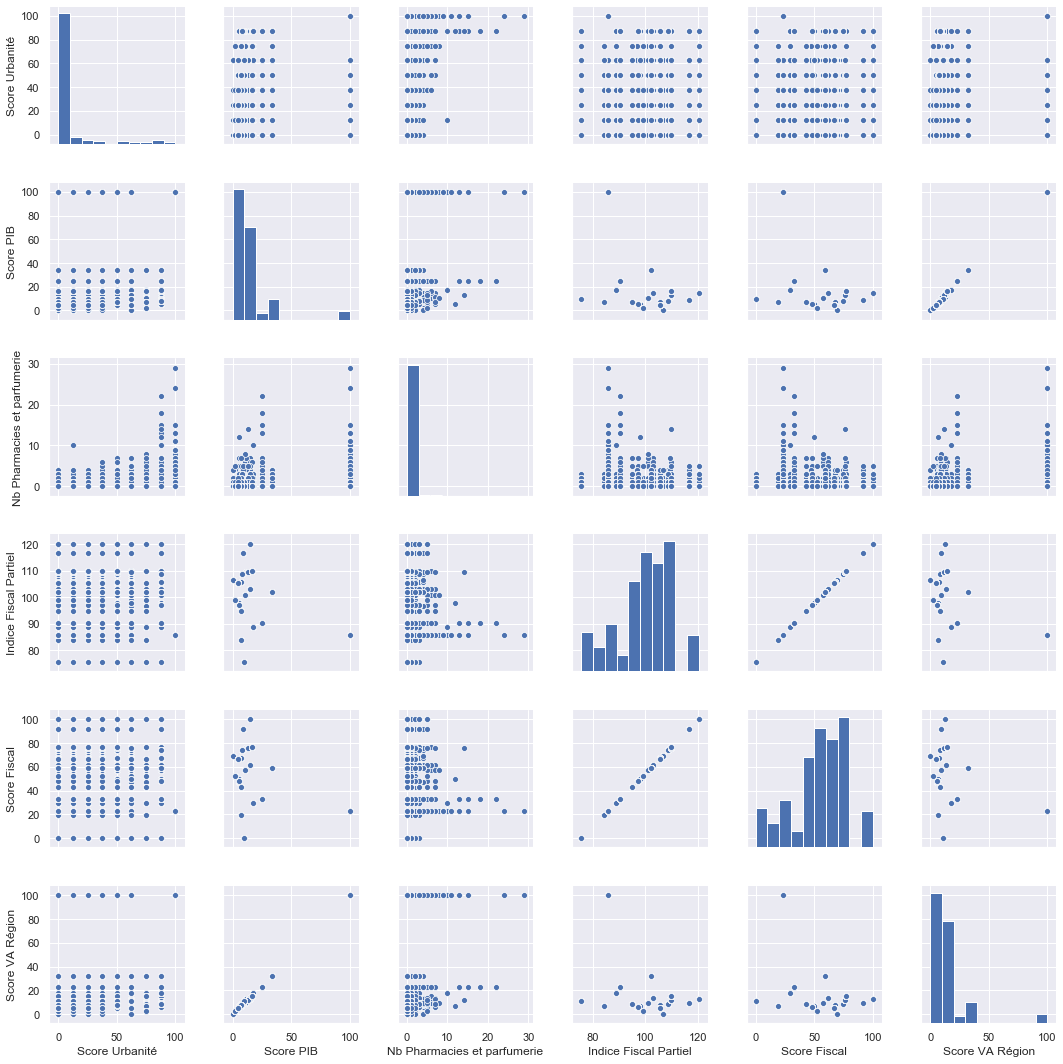

In [190]:
plt.figure(figsize=(20,10))
sns.pairplot(data_set[continuous_features[:6]], dropna=True)
plt.show()

> When plotting some of feature pairs we observe as observed in the correlatrion matrix, features that are totally correlated

> Let us remove features that are linearly corerelated at more than 95%

In [203]:
# Create correlation matrix
corr_matrix = data_set.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print('{} columns can be removed'.format(len(to_drop)))

49 columns can be removed


threshold can be fixed

In [191]:
to_drop

['Dynamique Entrepreneuriale Service et Commerce',
 'Score Fiscal',
 'Score Evasion Client',
 'Indice Synergie Médicale',
 'Score Synergie Médicale',
 'Nb pharmaciens Libéraux BV',
 'Indice Démographique',
 'Score Démographique',
 'Indice Ménages',
 'Score Ménages',
 'Population',
 'Nb Ménages',
 'Nb Résidences Principales',
 'Nb propriétaire',
 'Nb Logement',
 'Nb Log Vacants',
 'Nb Occupants Résidence Principale',
 'Nb Femme',
 'Nb Homme',
 'Nb Mineurs',
 'Nb Majeurs',
 'Nb Etudiants',
 'Nb Entreprises Secteur Services',
 'Nb Entreprises Secteur Commerce',
 'Nb Entreprises Secteur Industrie',
 'Nb Création Enteprises',
 'Nb Création Construction',
 'Nb Création Commerces',
 'Nb Création Services',
 'Moyenne Revenus Fiscaux Régionaux',
 'Nb Atifs',
 'Nb Actifs Salariés',
 'Nb Actifs Non Salariés',
 'Nb Logement Secondaire et Occasionnel',
 'Taux étudiants',
 'Dynamique Démographique INSEE',
 'Capacité Fiscale',
 'Taux Evasion Client',
 'Nb Education, santé, action sociale',
 'Nb Servi

**Some examples of correlations**

In [360]:
find_correlated_features(data_set, 'Score Fiscal', plot=False)

features  Correlation  sign
86                                       Score Fiscal     1.000000   1.0
85                              Indice Fiscal Partiel     1.000000   1.0
84                  Moyenne Revenus Fiscaux Régionaux     1.000000   1.0
83                             Moyenne Revnus fiscaux     0.692110   1.0
0              Nb Industries des biens intermédiaires     0.277184  -1.0
82             Moyenne Revenus Fiscaux Départementaux     0.239631   1.0
1                     Nb de Services aux particuliers     0.231358  -1.0
2                                      Nb de Commerce     0.226565  -1.0
3   Nb institution de Education, santé, action soc...     0.224148  -1.0
4                                     Score VA Région     0.223675  -1.0
5                            Valeur ajoutée régionale     0.223675  -1.0
6                Reg Moyenne Salaires Ouvrié Horaires     0.221523  -1.0
7                                           Score PIB     0.199217  -1.0
8                                       PIB Régionnal     0.199217  -1.0
9                Dep Moyenne Salaires Ouvrié Horaires     0.199027  -1.0
10                Reg Moyenne Salaires Cadre Horaires     0.183432  -1.0
11   Reg Moyenne Salaires Prof Intermédiaire Horaires     0.179116  -1.0
81                                                REG     0.158575   1.0
12   Dep Moyenne Salaires Prof Intermédiaire Horaires     0.150234  -1.0
13                Dep Moyenne Salaires Cadre Horaires     0.134068  -1.0
14              Reg Moyenne Salaires Employé Horaires     0.130259  -1.0
15              Dep Moyenne Salaires Employé Horaires     0.126006  -1.0
16                      Reg Moyenne Salaires Horaires     0.118555  -1.0
17                                     Taux Propriété     0.109308  -1.0
18                      Dep Moyenne Salaires Horaires     0.107606  -1.0
19                                    Evolution Pop %     0.103504  -1.0
20                        Score Croissance Population     0.103504  -1.0
21                                     Score Urbanité     0.102740  -1.0
80                       Score équipement de santé BV     0.094306   1.0
79                       Taux de motorisation Commune     0.094109   1.0
22                            Score Synergie Médicale     0.086996  -1.0
23                          Synergie Médicale COMMUNE     0.086996  -1.0
24                           Indice Synergie Médicale     0.086996  -1.0
78                          Nb Infirmiers Libéraux BV     0.083889   1.0
25                                Densité Médicale BV     0.068361  -1.0
26                               Evolution Population     0.058243  -1.0
77                      Dynamique Démographique INSEE     0.057942   1.0
27                                 Nb Actifs Salariés     0.037805  -1.0
28                         Dynamique Entrepreneuriale     0.036047  -1.0
76                                         Nb Camping     0.035581   1.0
29                                           Nb Atifs     0.035233  -1.0
30                                         Nb Mineurs     0.035202  -1.0
31                                           Nb Homme     0.034394  -1.0
32                  Nb Occupants Résidence Principale     0.034179  -1.0
33                                Score Démographique     0.033627  -1.0
34                               Indice Démographique     0.033627  -1.0
35                                         Population     0.033627  -1.0
36                                           Nb Femme     0.032477  -1.0
37                                         Nb Majeurs     0.030671  -1.0
38                        Nb Pharmacies et parfumerie     0.030004  -1.0
74                           Nb dentistes Libéraux BV     0.029293   1.0
75                         Nb pharmaciens Libéraux BV     0.029293   1.0
39                              Nb Création Commerces     0.027733  -1.0
40                  Score Croissance Entrepreneuriale     0.027080  -1.0
41                           N

> Here for example, 'Score Fiscal' is totally correlated to 'Indice Fiscal Partiel' and 'Moyenne Revenus Fiscaux Régionaux', hence we can remove two of these three features

In [206]:
find_correlated_features(data_set, 'Nb Femme', plot=False)

features  Correlation  sign
86                                           Nb Femme     1.000000   1.0
85                                         Population     0.999670   1.0
84                               Indice Démographique     0.999670   1.0
83                                Score Démographique     0.999670   1.0
82                                         Nb Majeurs     0.999511   1.0
81                  Nb Occupants Résidence Principale     0.999493   1.0
80                                         Nb Mineurs     0.998897   1.0
79                                           Nb Homme     0.998836   1.0
78                          Nb Résidences Principales     0.996102   1.0
77                                      Score Ménages     0.995977   1.0
76                                     Indice Ménages     0.995977   1.0
75                                         Nb Ménages     0.995977   1.0
74                                           Nb Atifs     0.992740   1.0
73                                 Nb Actifs Salariés     0.990977   1.0
72                                        Nb Logement     0.985876   1.0
71                                    Nb propriétaire     0.974038   1.0
70                         Dynamique Entrepreneuriale     0.965625   1.0
69                   Nb Entreprises Secteur Industrie     0.964145   1.0
68                           Nb Santé, action sociale     0.962589   1.0
67                             Nb Actifs Non Salariés     0.960816   1.0
66     Dynamique Entrepreneuriale Service et Commerce     0.959469   1.0
65                    Nb Entreprises Secteur Services     0.958878   1.0
64                Nb Education, santé, action sociale     0.957231   1.0
63              Nb Services personnels et domestiques     0.956748   1.0
62                                       Nb Etudiants     0.950744   1.0
61                    Nb Entreprises Secteur Commerce     0.947783   1.0
60                             Nb Création Enteprises     0.942979   1.0
59                  Score Croissance Entrepreneuriale     0.940252   1.0
58                               Nb Création Services     0.935074   1.0
57                                     Nb Log Vacants     0.932249   1.0
56                              Nb Création Commerces     0.928207   1.0
55                Nb Entreprises Secteur Construction     0.896928   1.0
54                          Synergie Médicale COMMUNE     0.896895   1.0
53                           Indice Synergie Médicale     0.896895   1.0
52                            Score Synergie Médicale     0.896895   1.0
51                          Nb Création Industrielles     0.892517   1.0
50                                     Taux étudiants     0.891995   1.0
49                           Nb Création Construction     0.856661   1.0
48                               Evolution Population     0.832951   1.0
0                       Dynamique Démographique INSEE     0.819141  -1.0
1                                       Capacité Fisc     0.711010  -1.0
2                                    Capacité Fiscale     0.711010  -1.0
47                                           Nb Hotel     0.643105   1.0
46                                     Capacité Hotel     0.622869   1.0
45                                Taux Evasion Client     0.619685   1.0
44                              Indice Evasion Client     0.619685   1.0
43                               Score Evasion Client     0.619685   1.0
42                        Nb Pharmacies et parfumerie     0.546714   1.0
41                                     Score Urbanité     0.427974   1.0
3                        Taux de motorisation Commune     0.351028  -1.0
40              Nb Logement Secondaire et Occasionnel     0.295283   1.0
39                          Nb Résidences Secondaires     0.295251   1.0
38                                Densité Médicale BV     0.191974   1.0
37                      Dep Moyenne Salaires Horaires     0.158236   1.0
36  Nb institution de Educatio

> Same for 'Nb Femme', but this time there are more than only 3 correlated features (even if the correlation value isn't equal to 1, it is still extremely high to consider them separatly)

In [377]:
# Drop highly correlated columns
data_set_update_1 = data_set.drop(to_drop, axis=1)

In [378]:
count_types_features(data_set_update_1)

float64    25
object     14
int64      13
dtype: int64

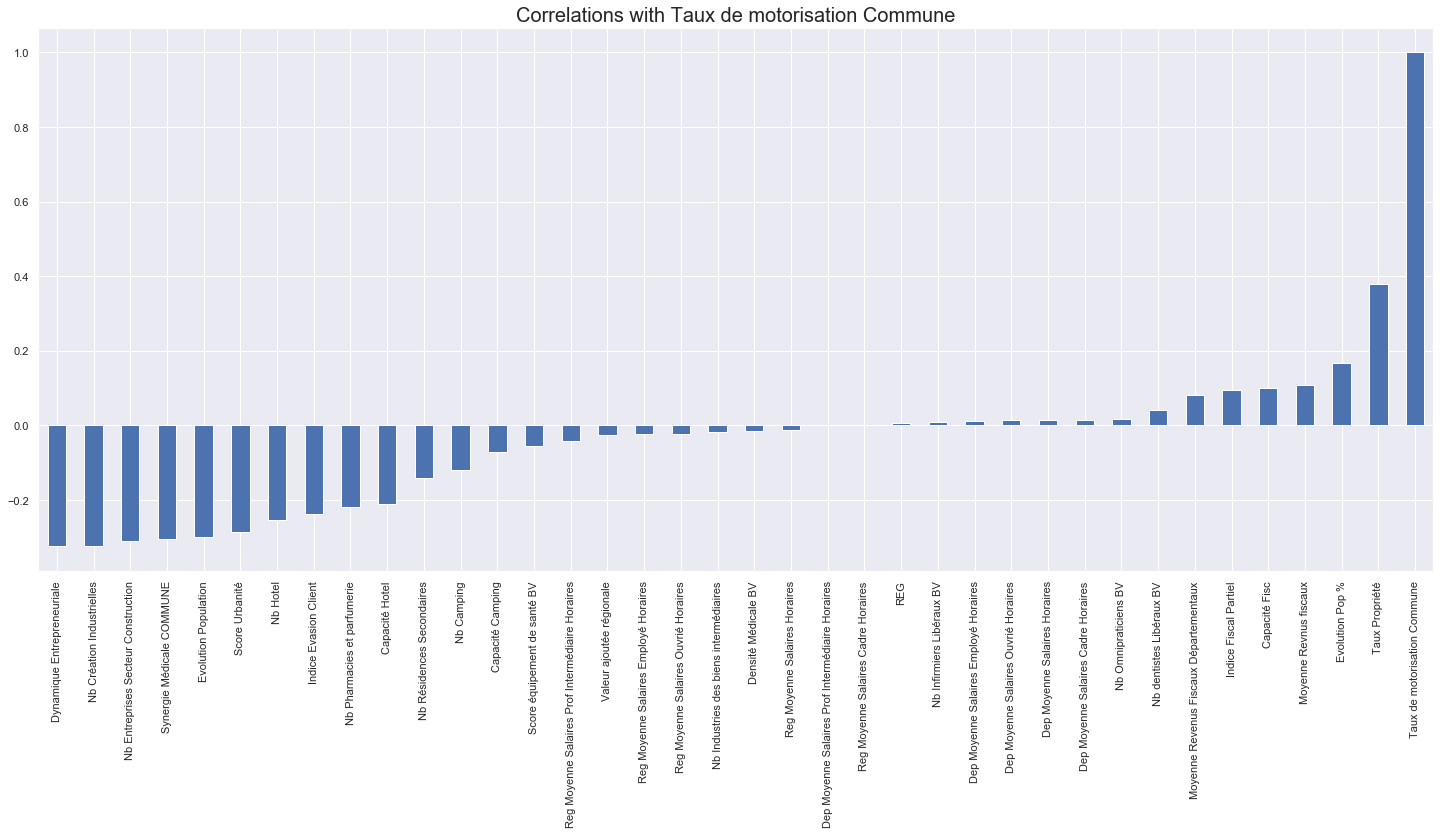

features  Correlation  sign
37                      Taux de motorisation Commune     1.000000   1.0
36                                    Taux Propriété     0.379157   1.0
0                         Dynamique Entrepreneuriale     0.324639  -1.0
1                          Nb Création Industrielles     0.324513  -1.0
2                Nb Entreprises Secteur Construction     0.309667  -1.0
3                          Synergie Médicale COMMUNE     0.304676  -1.0
4                               Evolution Population     0.300172  -1.0
5                                     Score Urbanité     0.286012  -1.0
6                                           Nb Hotel     0.253676  -1.0
7                              Indice Evasion Client     0.237776  -1.0
8                        Nb Pharmacies et parfumerie     0.217518  -1.0
9                                     Capacité Hotel     0.210574  -1.0
35                                   Evolution Pop %     0.166941   1.0
10                         Nb Résidences Secondaires     0.141953  -1.0
11                                        Nb Camping     0.119409  -1.0
34                            Moyenne Revnus fiscaux     0.109102   1.0
33                                     Capacité Fisc     0.099040   1.0
32                             Indice Fiscal Partiel     0.094109   1.0
31            Moyenne Revenus Fiscaux Départementaux     0.081692   1.0
12                                  Capacité Camping     0.070211  -1.0
13                      Score équipement de santé BV     0.054665  -1.0
14  Reg Moyenne Salaires Prof Intermédiaire Horaires     0.041095  -1.0
30                          Nb dentistes Libéraux BV     0.040305   1.0
15                          Valeur ajoutée régionale     0.025593  -1.0
16             Reg Moyenne Salaires Employé Horaires     0.023220  -1.0
17              Reg Moyenne Salaires Ouvrié Horaires     0.022002  -1.0
29                              Nb Omnipraticiens BV     0.018027   1.0
18            Nb Industries des biens intermédiaires     0.017409  -1.0
28               Dep Moyenne Salaires Cadre Horaires     0.014523   1.0
19                               Densité Médicale BV     0.014477  -1.0
27                     Dep Moyenne Salaires Horaires     0.014204   1.0
26              Dep Moyenne Salaires Ouvrié Horaires     0.013577   1.0
20                     Reg Moyenne Salaires Horaires     0.013483  -1.0
25             Dep Moyenne Salaires Employé Horaires     0.011596   1.0
24                         Nb Infirmiers Libéraux BV     0.009140   1.0
23                                               REG     0.005313   1.0
22               Reg Moyenne Salaires Cadre Horaires     0.001975   1.0
21  Dep Moyenne Salaires Prof Intermédiaire Horaires     0.000027   1.0

In [210]:
find_correlated_features(data_set_update_1, target, plot=True)

In [211]:
data_set_up1_overview_feats = overview_features(data_set_update_1)
categorical_features = list(data_set_up1_overview_feats[data_set_up1_overview_feats.Type == 'object'].index)
categorical_features.remove('CODGEO')
print('Number of categorical features: {}'.format(len(categorical_features)))

integer_features = list(data_set_up1_overview_feats[data_set_up1_overview_feats.Type == 'int64'].index)
print('Number of integer features    : {}'.format(len(integer_features)))

continuous_features = list(data_set_up1_overview_feats[data_set_up1_overview_feats.Type == 'float64'].index)
print('Number of continuous features : {}'.format(len(continuous_features)))

Number of categorical features: 13
Number of integer features    : 13
Number of continuous features : 25


**Let us plot the evolution of the target with continuous features (one by one) and see if there is any non linear relation between the target and any of these features that can be perceived visually**

/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


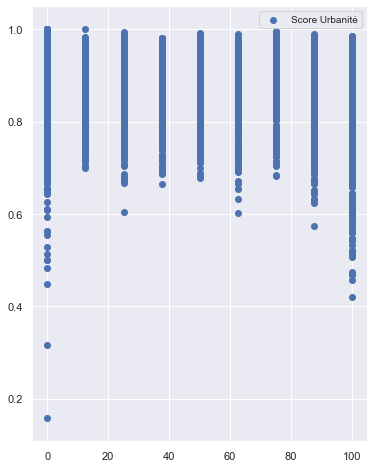

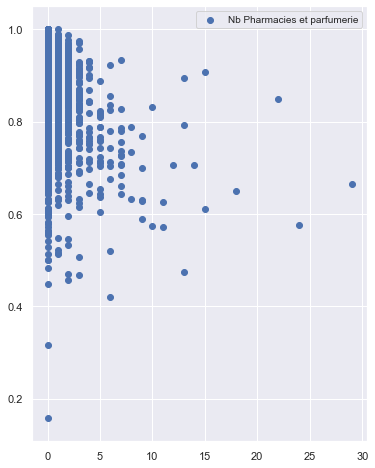

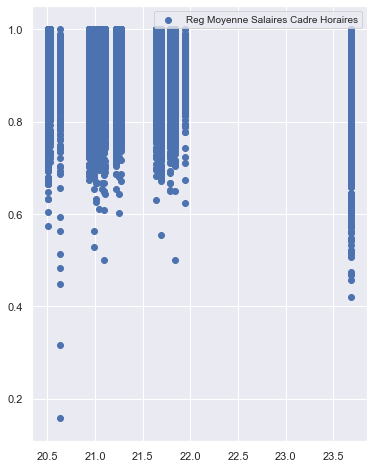

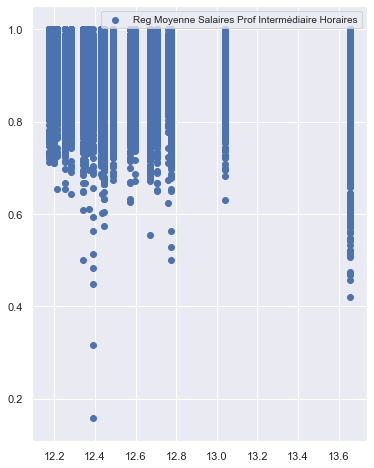

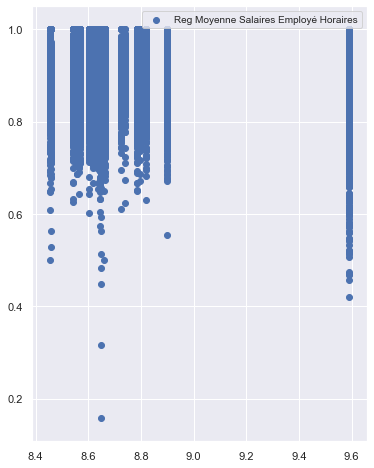

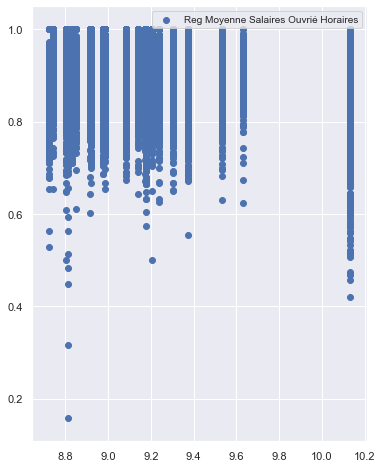

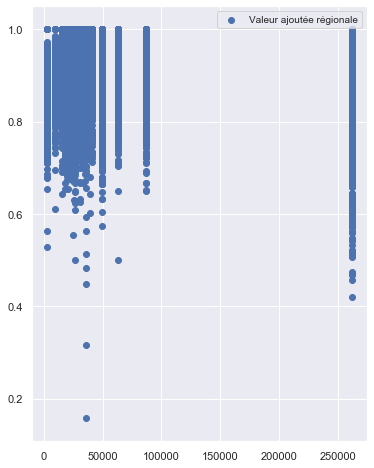

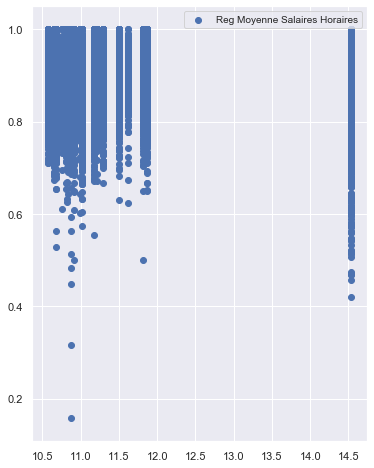

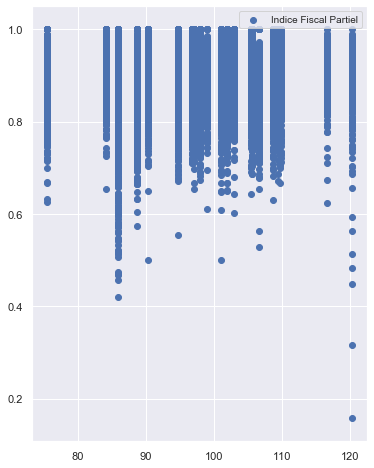

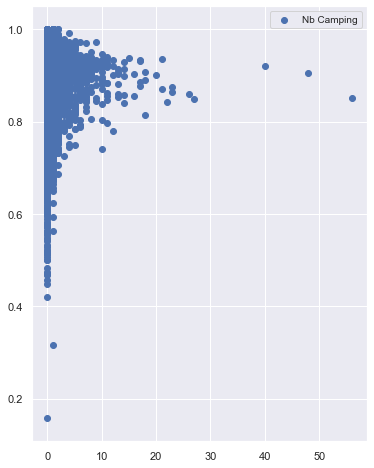

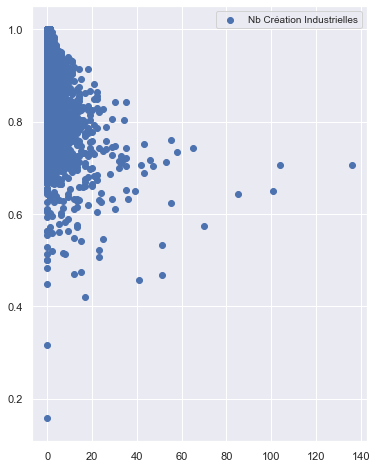

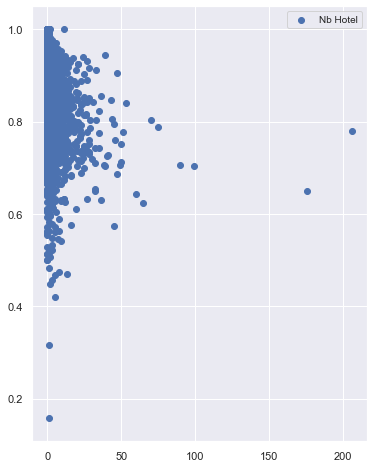

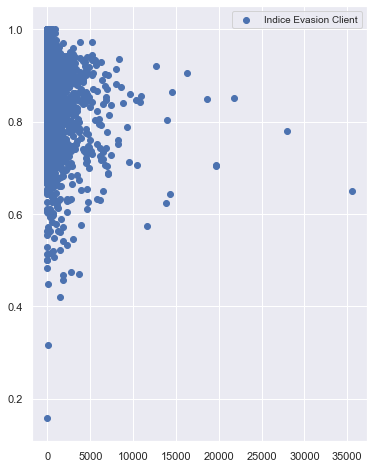

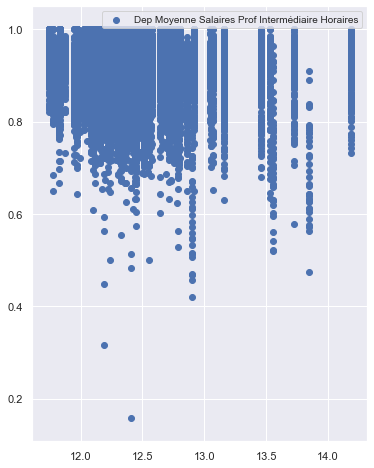

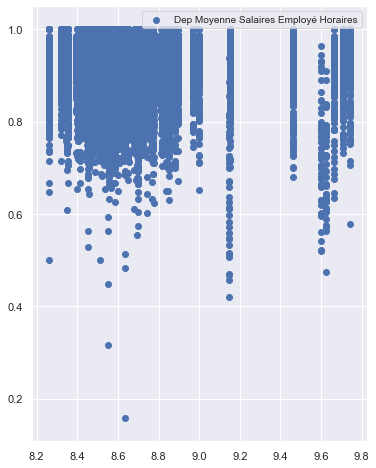

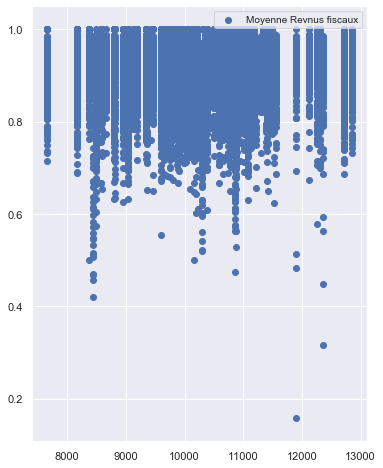

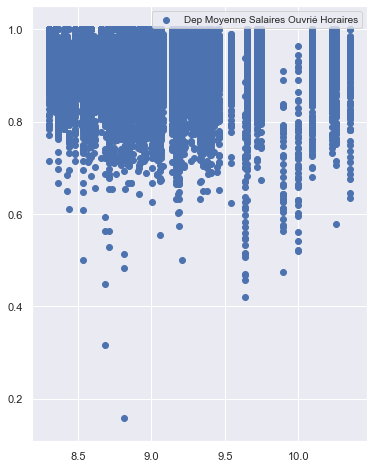

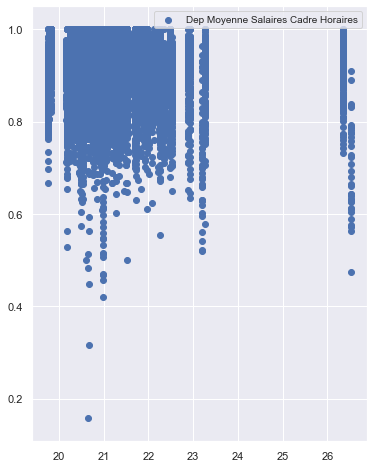

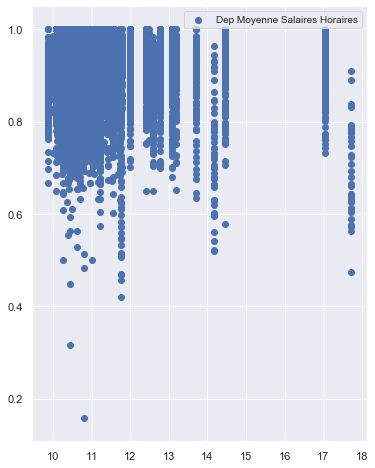

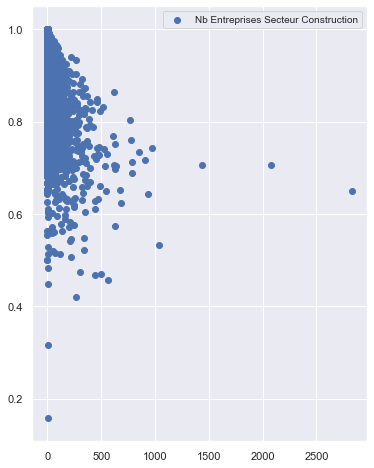

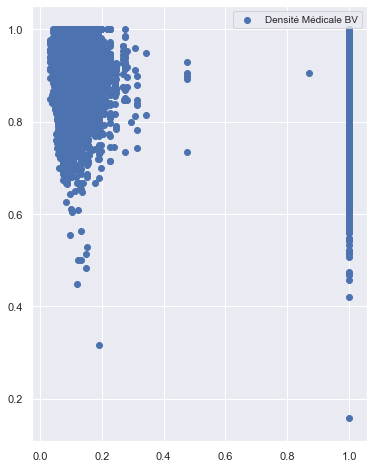

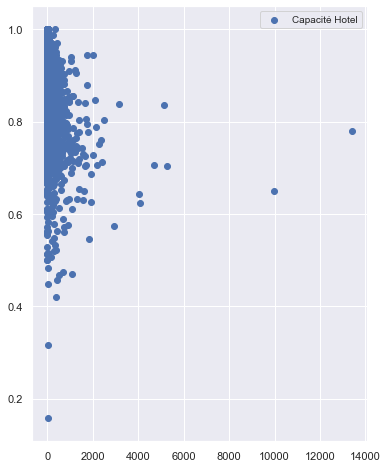

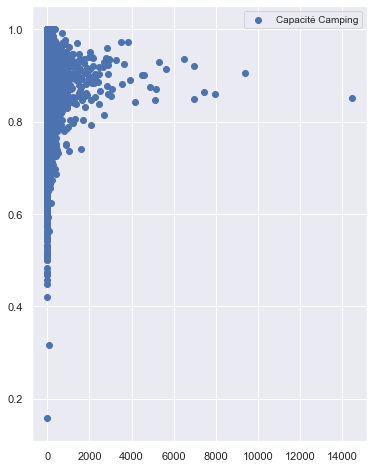

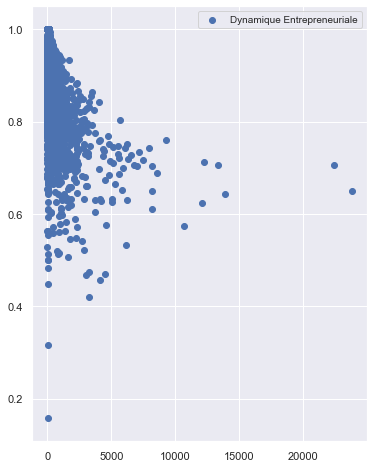

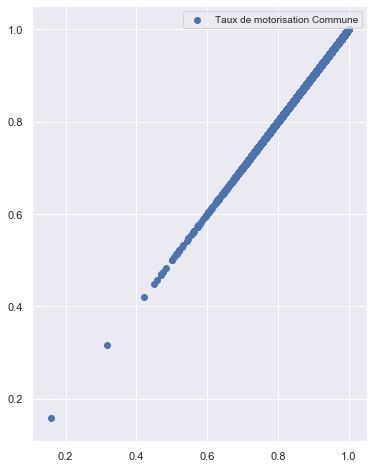

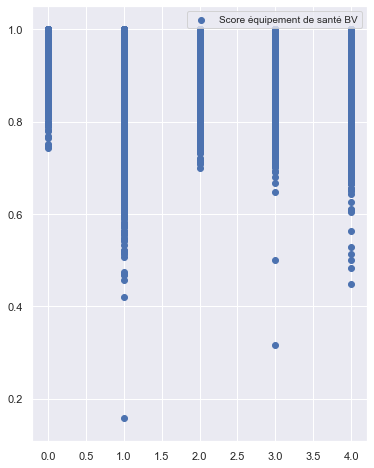

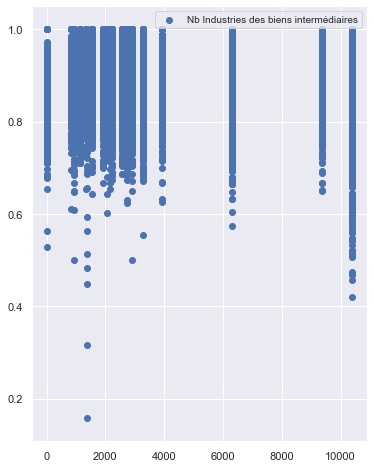

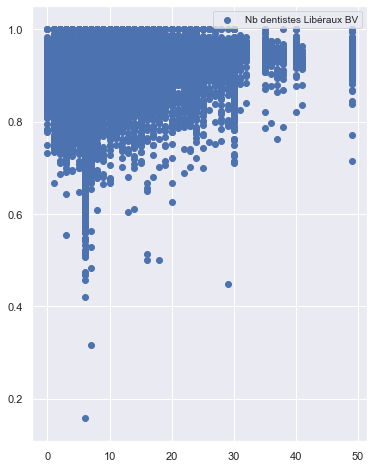

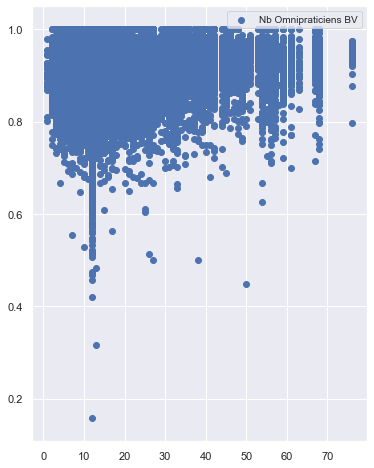

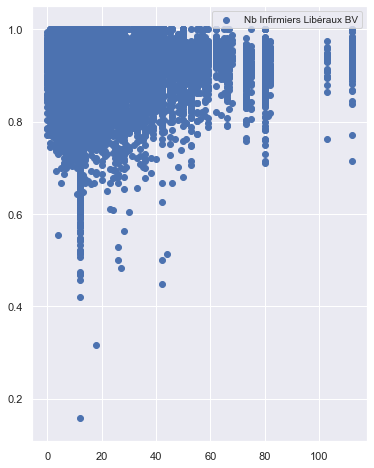

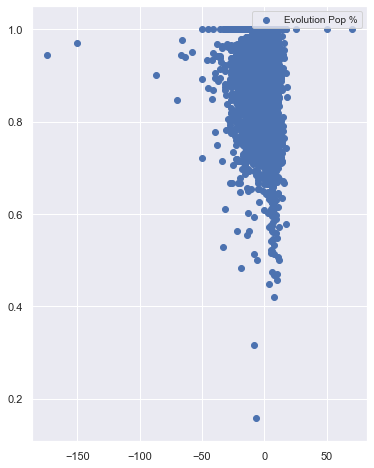

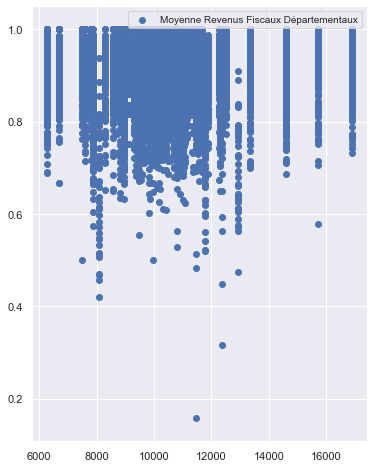

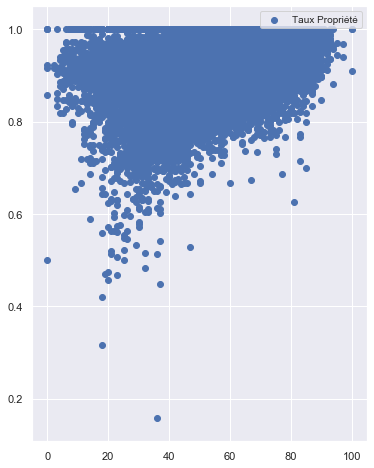

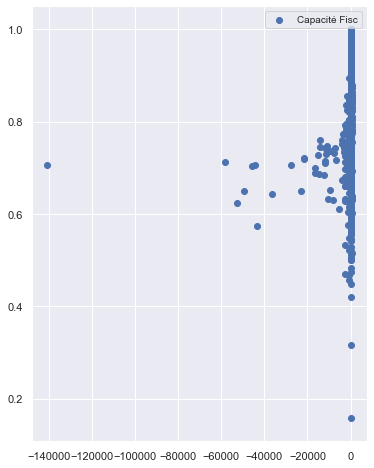

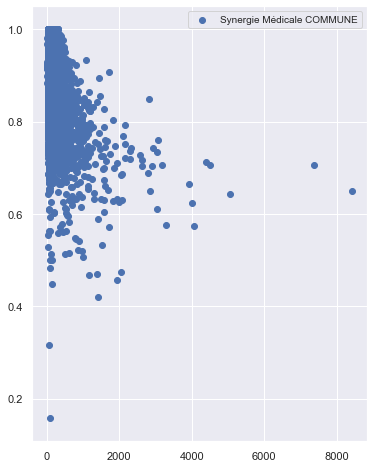

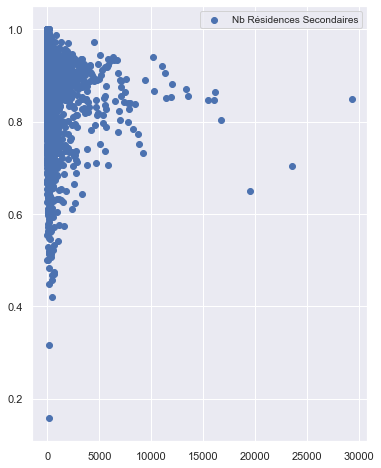

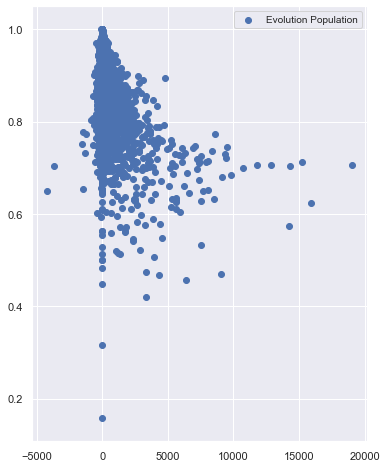

In [501]:
for cont_feat in continuous_features:
    if cont_feat in data_set_update_1.columns:
        plt.figure(figsize=(6,8))
        plt.scatter(data_set_update_1[cont_feat], data_set_update_1[target], label=cont_feat)
        plt.legend(prop={'size': 10})



/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 432x576 with 0 Axes>

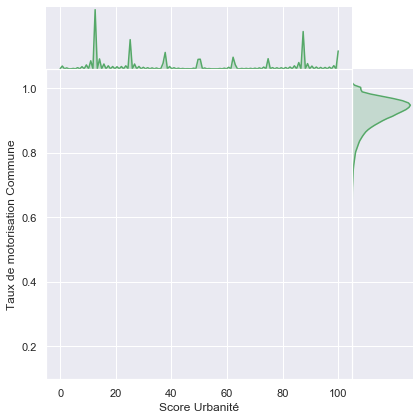

<Figure size 432x576 with 0 Axes>

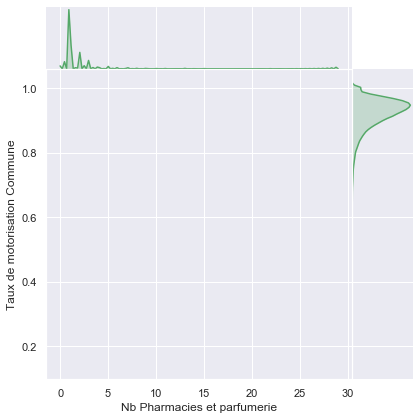

<Figure size 432x576 with 0 Axes>

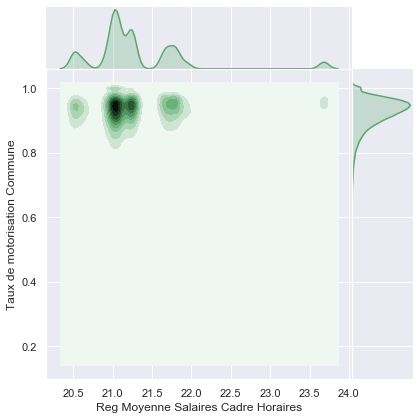

<Figure size 432x576 with 0 Axes>

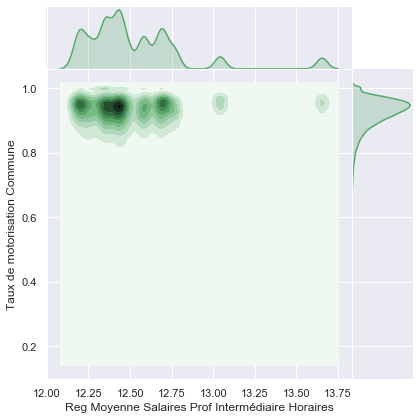

<Figure size 432x576 with 0 Axes>

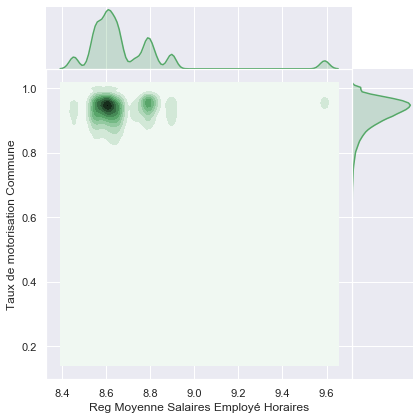

<Figure size 432x576 with 0 Axes>

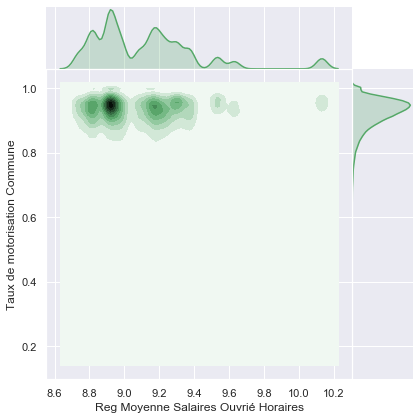

<Figure size 432x576 with 0 Axes>

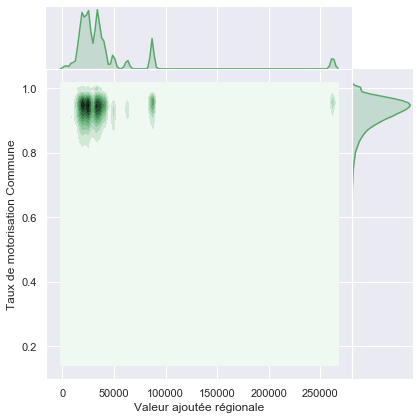

<Figure size 432x576 with 0 Axes>

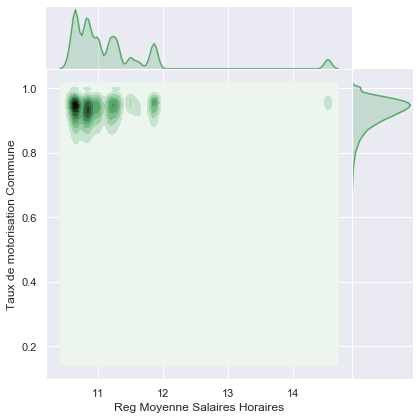

<Figure size 432x576 with 0 Axes>

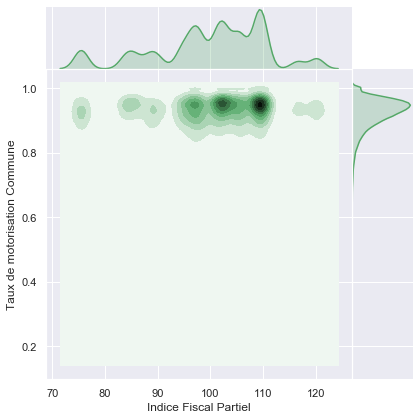

<Figure size 432x576 with 0 Axes>

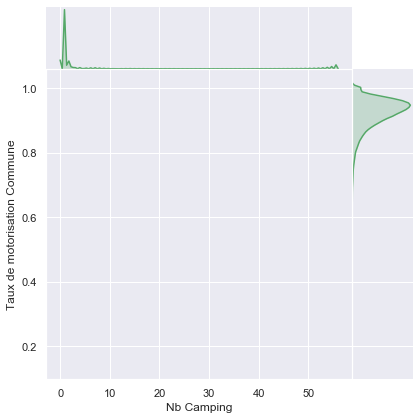

<Figure size 432x576 with 0 Axes>

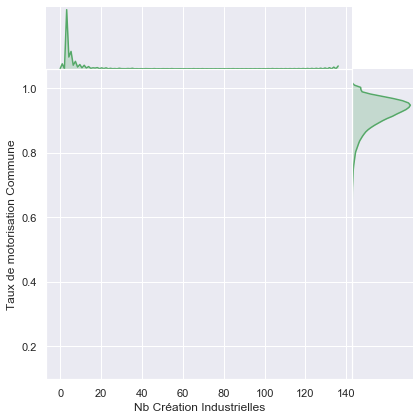

<Figure size 432x576 with 0 Axes>

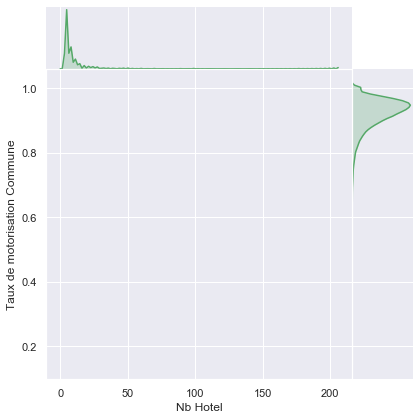

<Figure size 432x576 with 0 Axes>

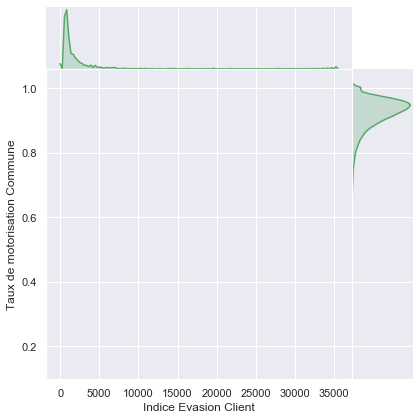

<Figure size 432x576 with 0 Axes>

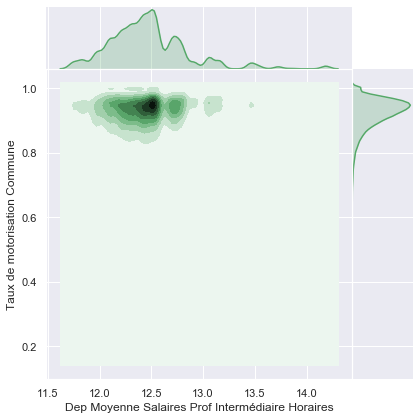

<Figure size 432x576 with 0 Axes>

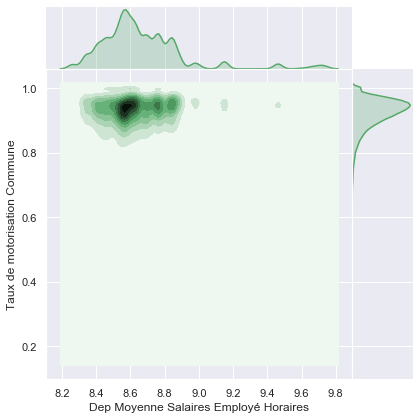

<Figure size 432x576 with 0 Axes>

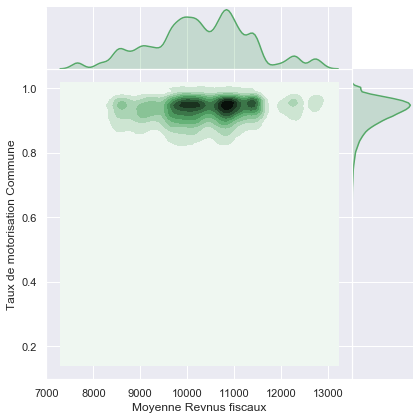

<Figure size 432x576 with 0 Axes>

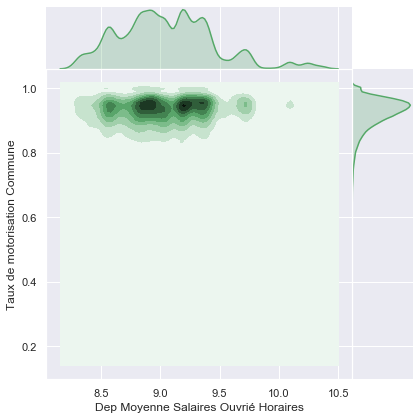

<Figure size 432x576 with 0 Axes>

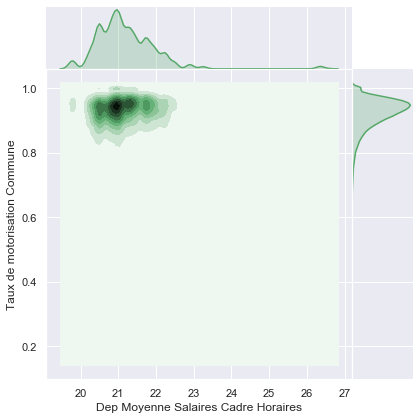

<Figure size 432x576 with 0 Axes>

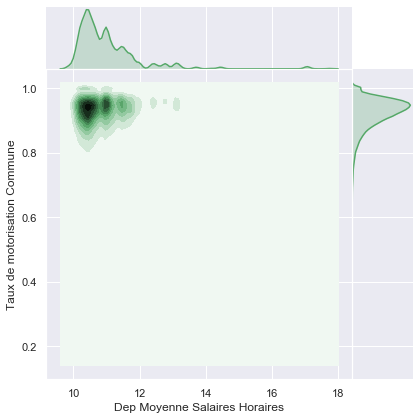

<Figure size 432x576 with 0 Axes>

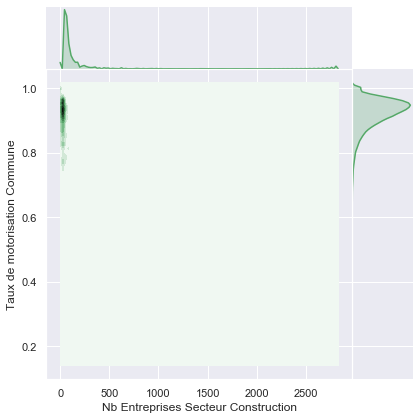

<Figure size 432x576 with 0 Axes>

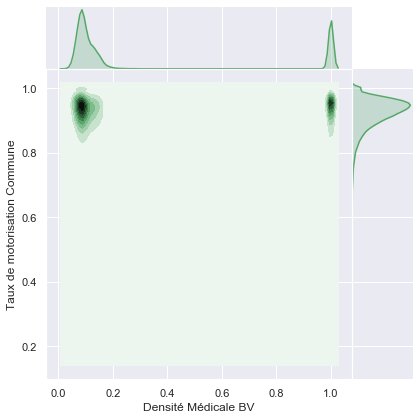

<Figure size 432x576 with 0 Axes>

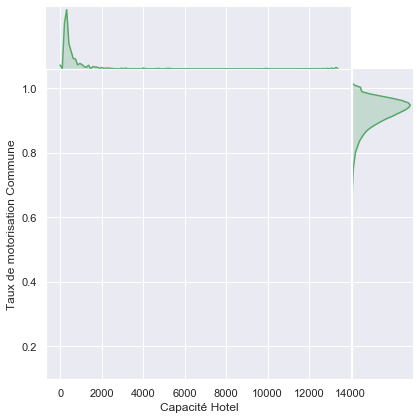

<Figure size 432x576 with 0 Axes>

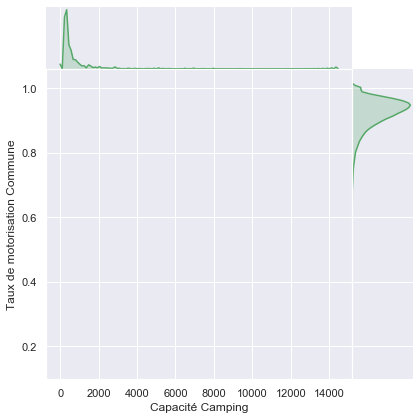

<Figure size 432x576 with 0 Axes>

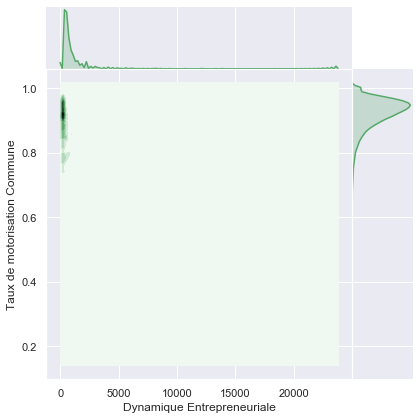

<Figure size 432x576 with 0 Axes>

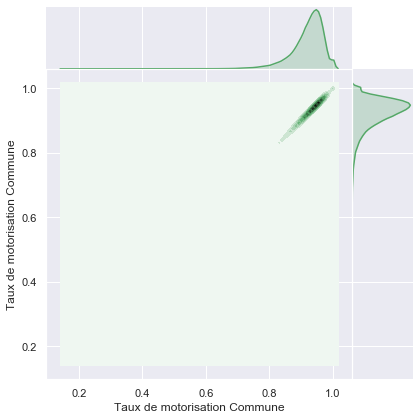

<Figure size 432x576 with 0 Axes>

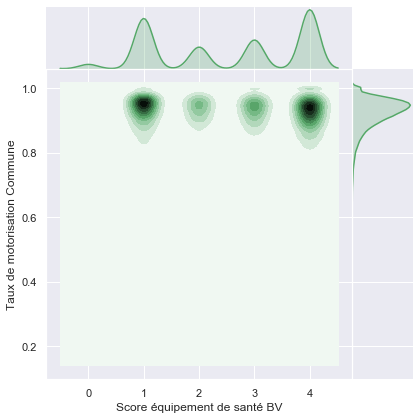

<Figure size 432x576 with 0 Axes>

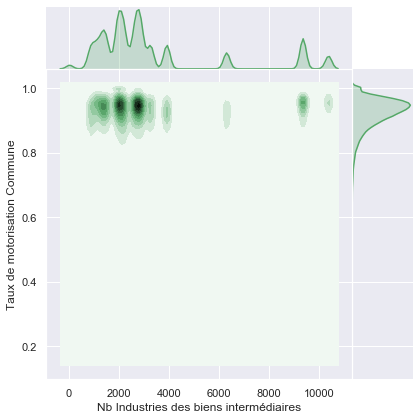

<Figure size 432x576 with 0 Axes>

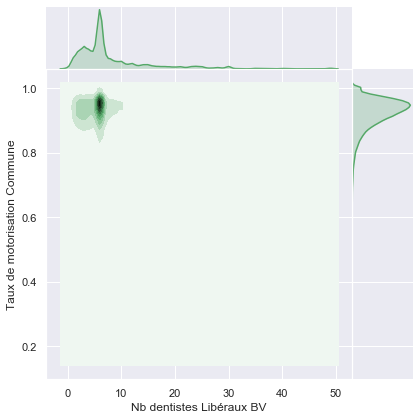

<Figure size 432x576 with 0 Axes>

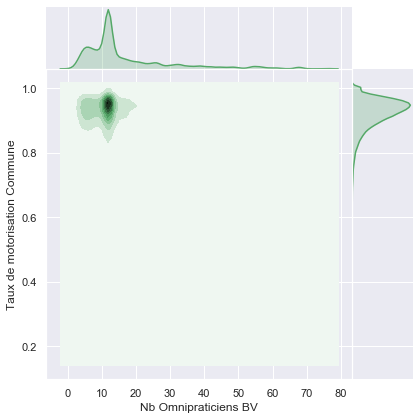

<Figure size 432x576 with 0 Axes>

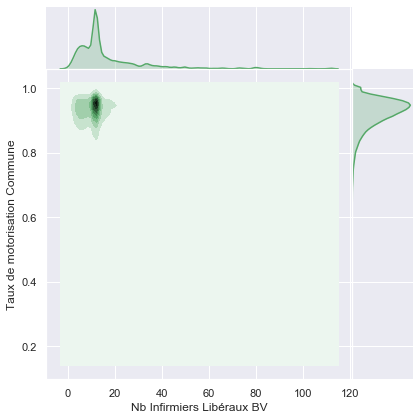

<Figure size 432x576 with 0 Axes>

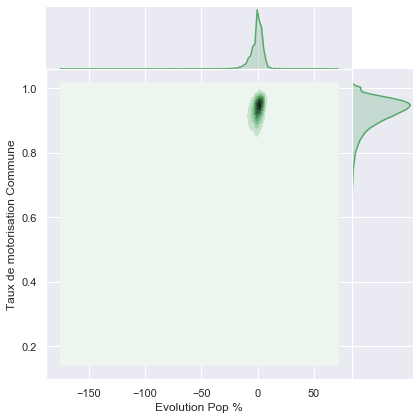

<Figure size 432x576 with 0 Axes>

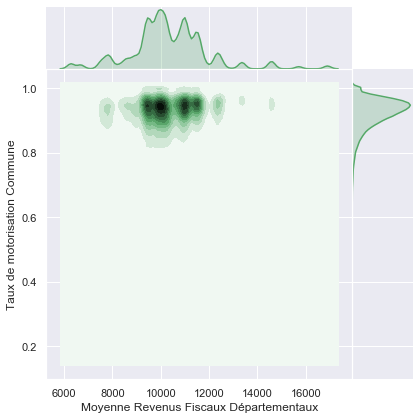

<Figure size 432x576 with 0 Axes>

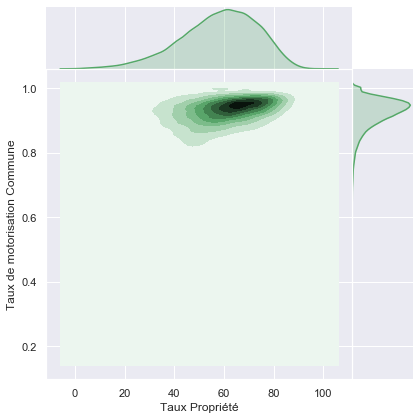

<Figure size 432x576 with 0 Axes>

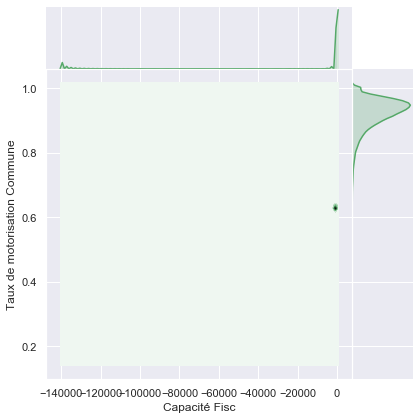

<Figure size 432x576 with 0 Axes>

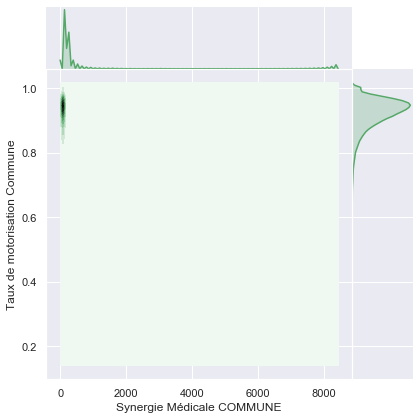

<Figure size 432x576 with 0 Axes>

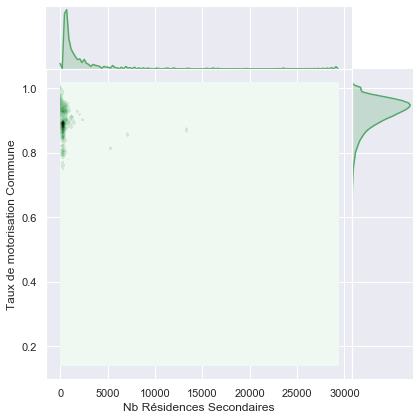

<Figure size 432x576 with 0 Axes>

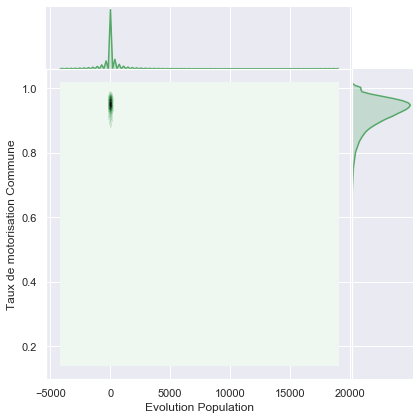

In [499]:
for cont_feat in continuous_features:
    if cont_feat in data_set_update_1.columns:
        plt.figure(figsize=(6,8))
        sns.jointplot(cont_feat, target, data=data_set_update_1,
                           kind="kde", space=0, color="g")

    #plt.figure(figsize=(6,8))
    #plt.scatter(data_set_update_1[cont_feat], data_set_update_1[target], label=cont_feat)
    #plt.legend(prop={'size': 10})

> **Observation 1**: From the plots we observe some rude separation on some features ('Valeur ajoutée régionale for example), it might be the big cities (Paris for example)

**idea 1**: Should we separate these data and build a model for each ?

> **Observation 2**: We can't observe an evident relation between the target and the continuous features, except a bit for features related to **Camping**

#### Let us detect these outliers

> Let us see first if these outliers corresponds to the same 'Code Postal'

In [220]:
print(list(data_set_update_1[data_set_update_1['Reg Moyenne Salaires Ouvrié Horaires'] > 10].CP.unique()))
print(list(data_set_update_1[data_set_update_1['Reg Moyenne Salaires Employé Horaires'] > 9].CP.unique()))

set(data_set_update_1[data_set_update_1['Reg Moyenne Salaires Ouvrié Horaires'] > 10].CODGEO.unique()) - set(data_set_update_1[data_set_update_1['Reg Moyenne Salaires Employé Horaires'] > 9].CODGEO.unique())

rich_codgeo = list(data_set_update_1[data_set_update_1['Reg Moyenne Salaires Ouvrié Horaires'] > 10].CODGEO.unique())
rich_CP = list(data_set_update_1[data_set_update_1['Reg Moyenne Salaires Ouvrié Horaires'] > 10].CP.unique())


['77', '78', '91', '92', '93', '94', '95']
['77', '78', '91', '92', '93', '94', '95']


It does correspond to the same 'Code Postal'

#### Boxplot to visualize the distribution of the target by CP

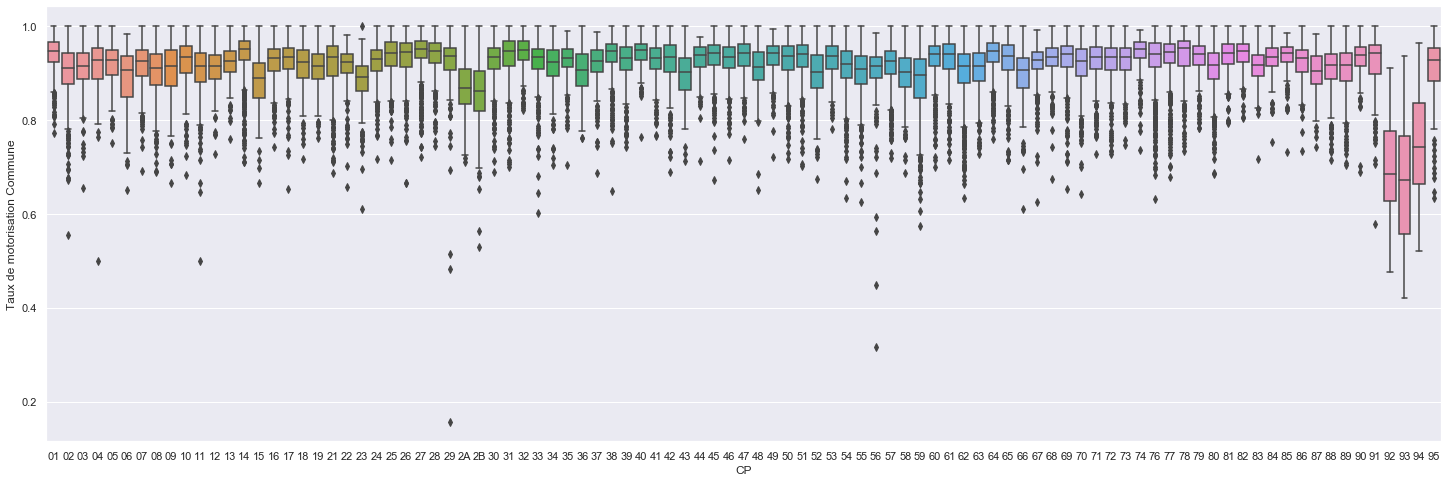

In [343]:
plt.figure(figsize=(25,8))
sns.boxplot(x='CP', y=target, data=data_set_update_1)
plt.savefig("Target Ditribution by CP")

> We observe 3 categories which values are far from the others. They are part of the listed rich cities

We make the same plots but without the outliers observed before

/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


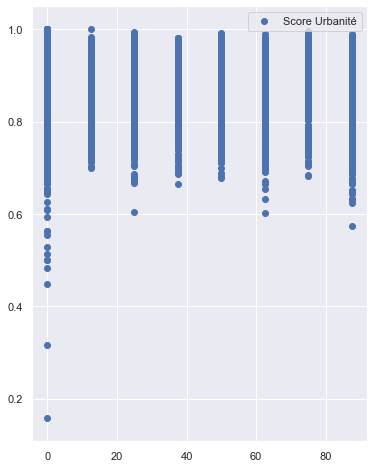

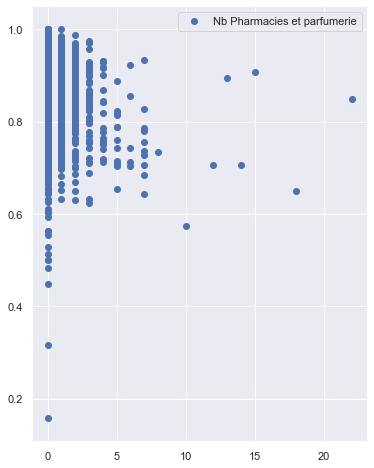

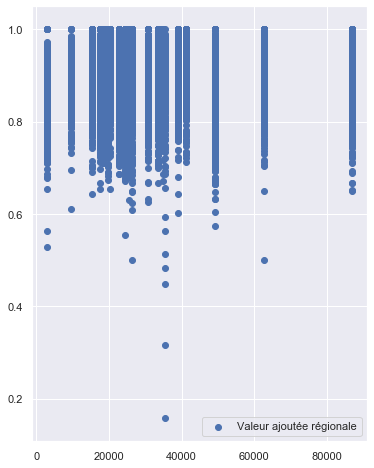

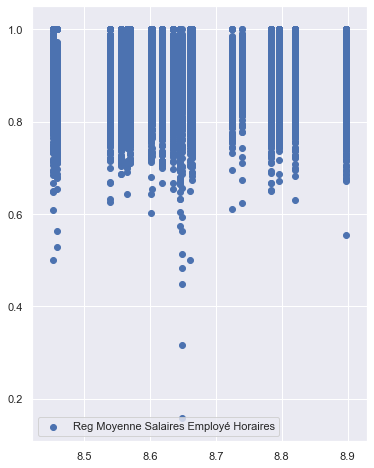

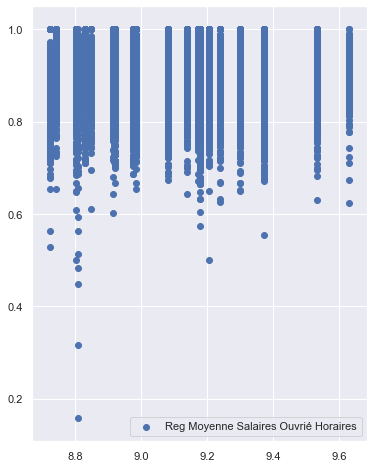

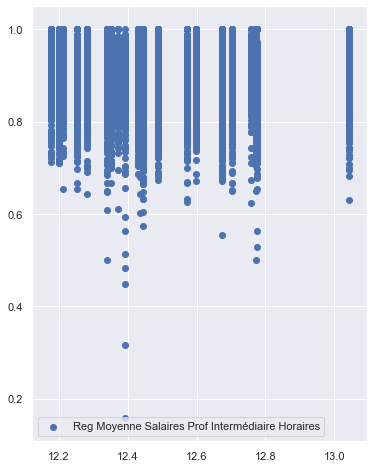

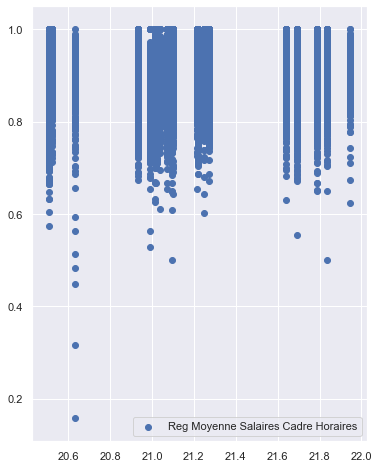

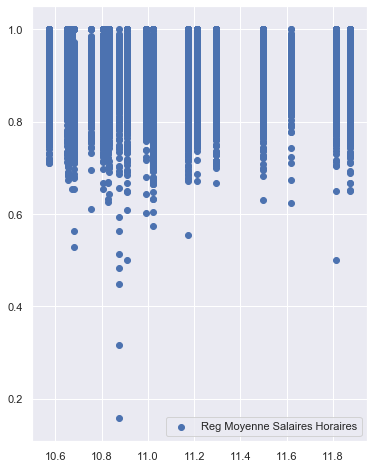

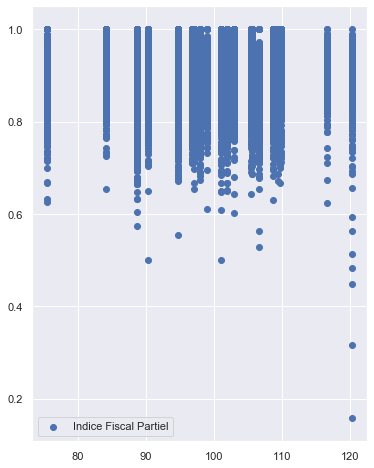

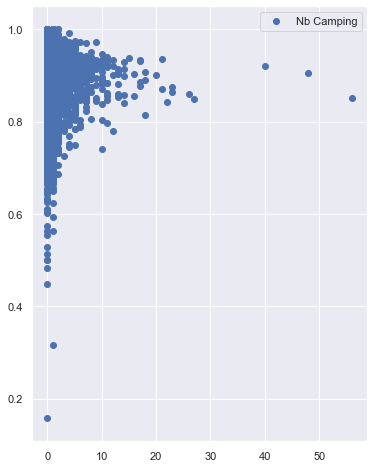

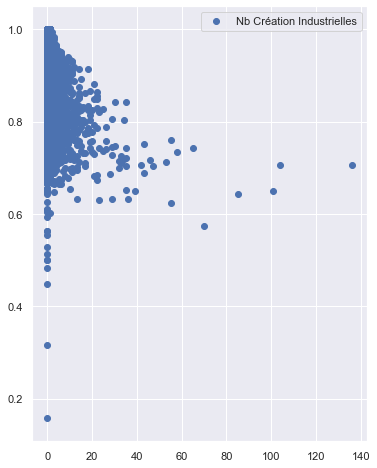

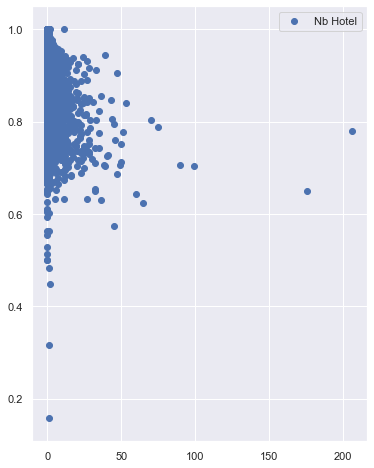

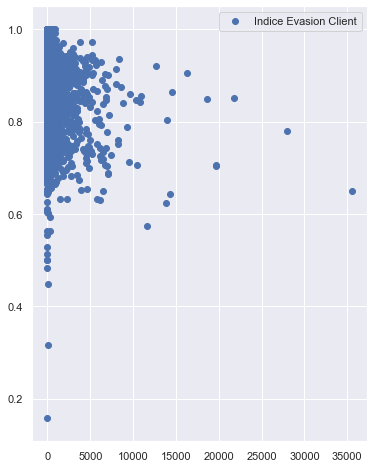

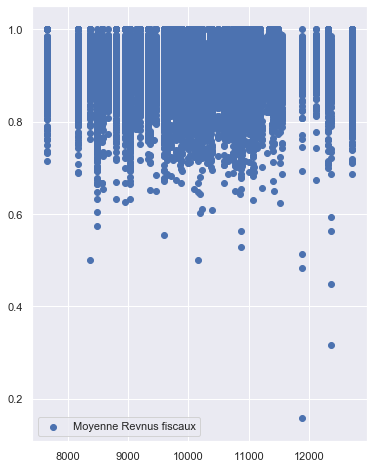

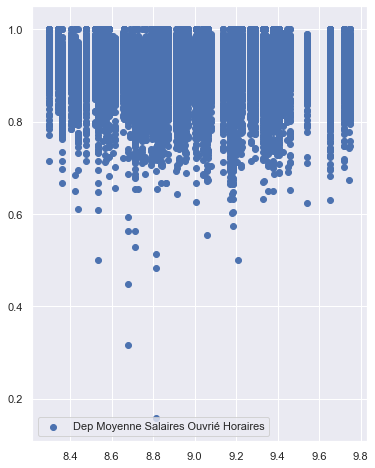

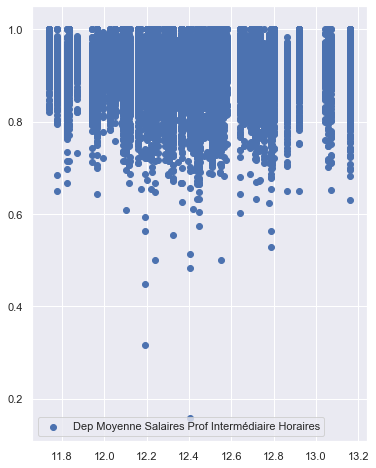

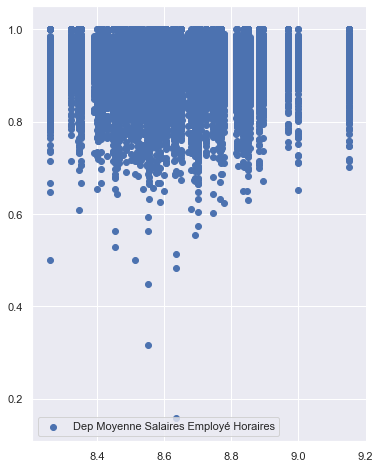

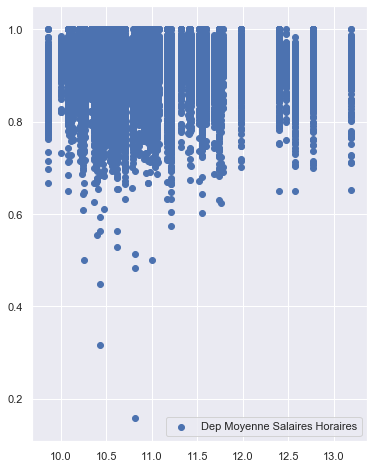

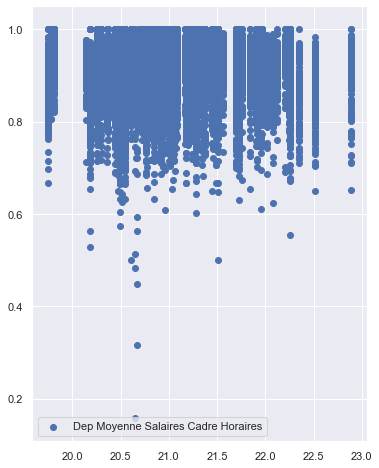

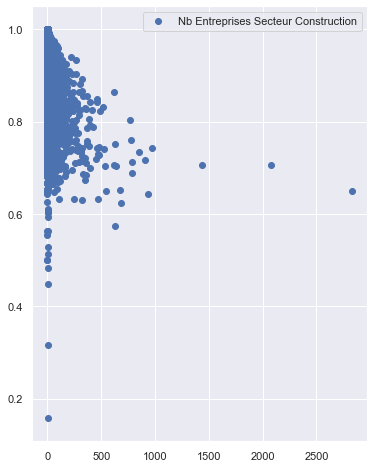

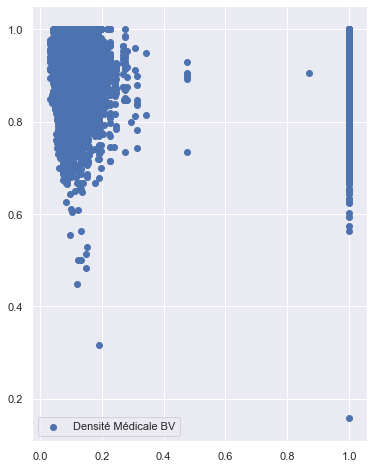

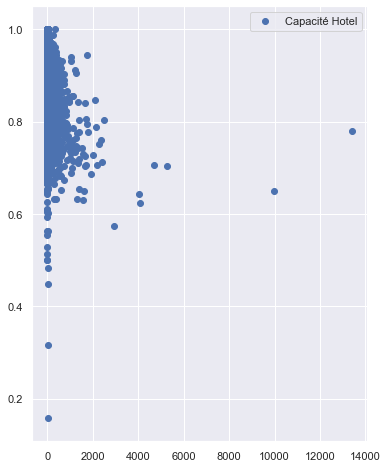

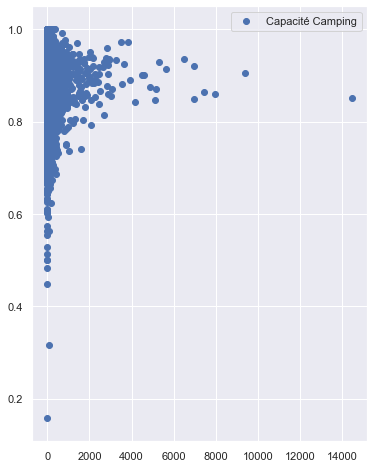

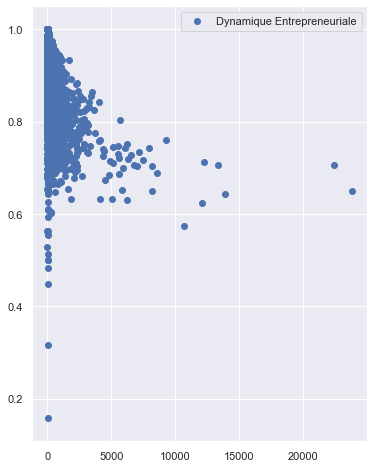

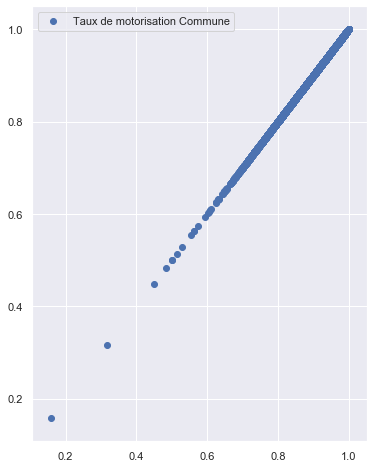

In [222]:
for cont_feat in continuous_features:
    plt.figure(figsize=(6,8))
    data_without_outlier = data_set_update_1[~data_set_update_1['CODGEO'].isin(rich_codgeo)]
    plt.scatter(data_without_outlier[cont_feat], data_without_outlier[target], label=cont_feat)
    plt.legend()

No noticeable difference after removing the outliers.

### Categorical features

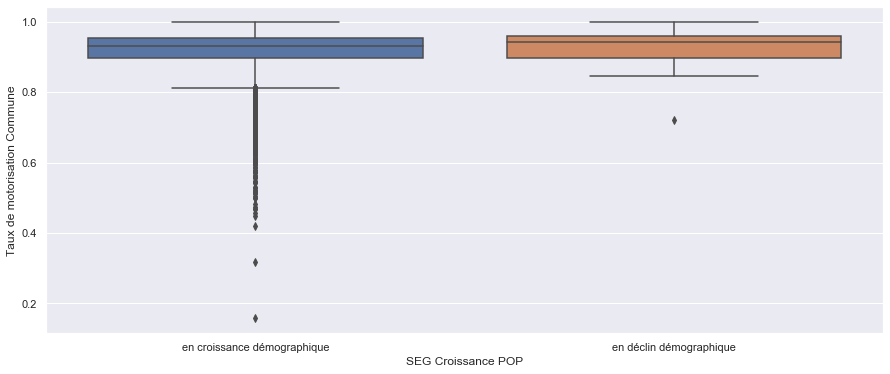

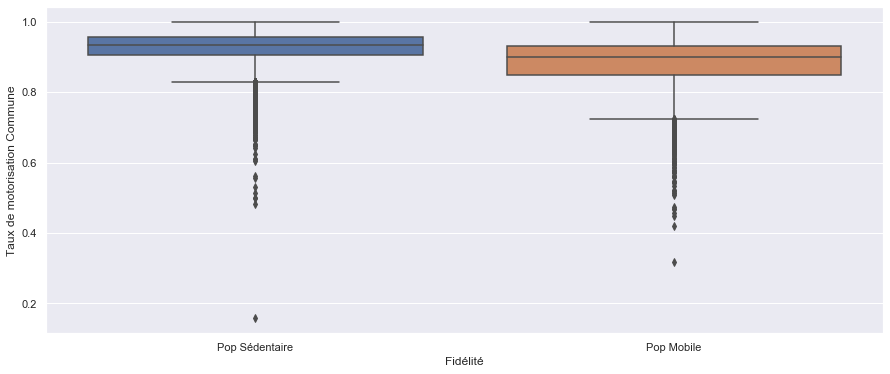

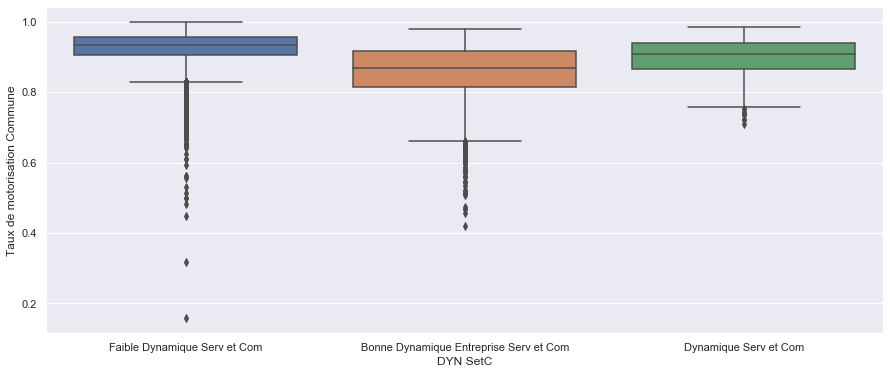

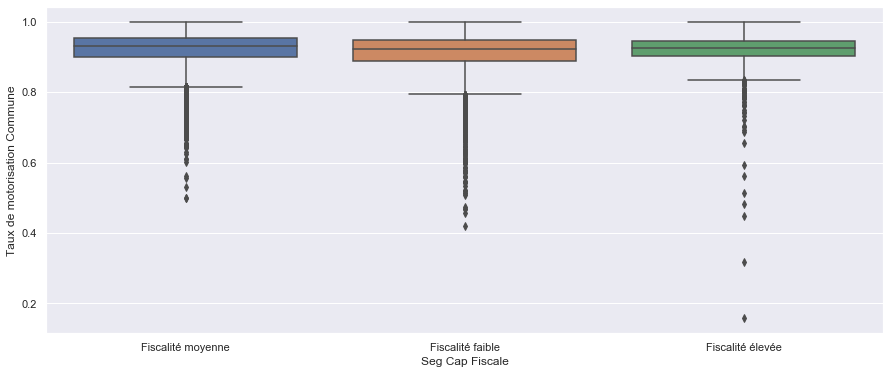

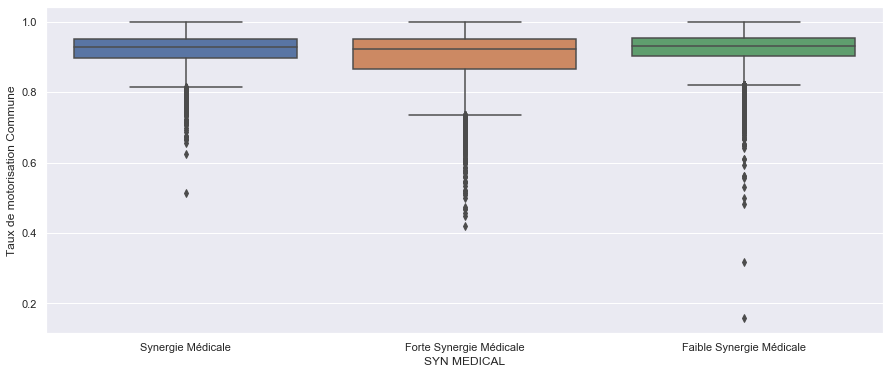

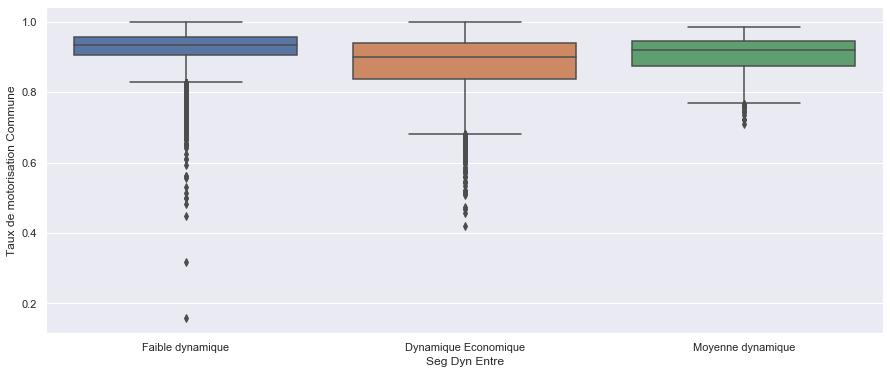

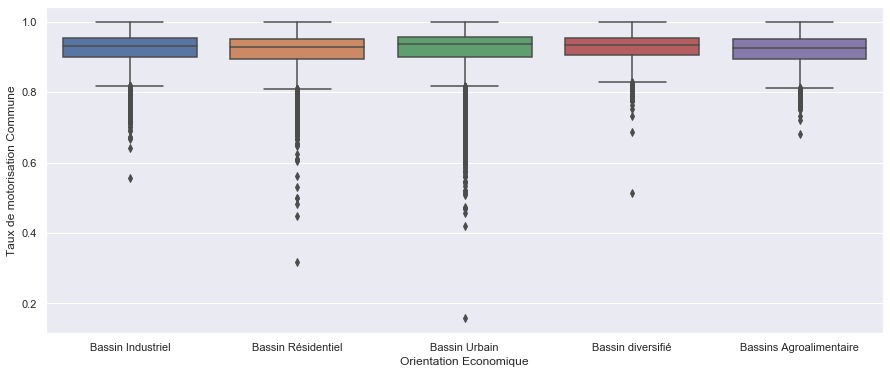

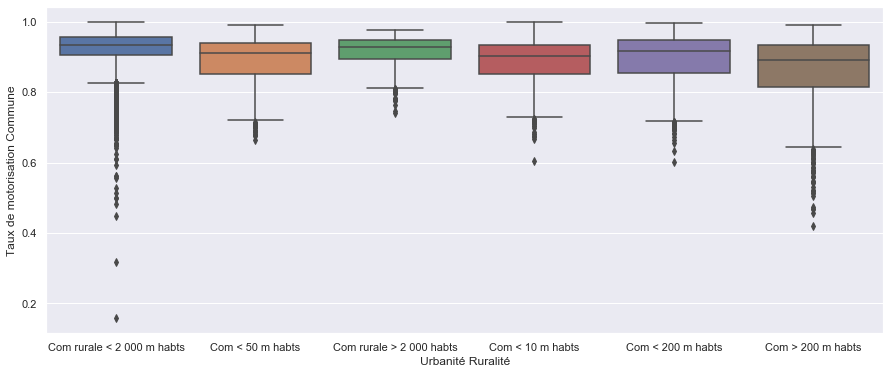

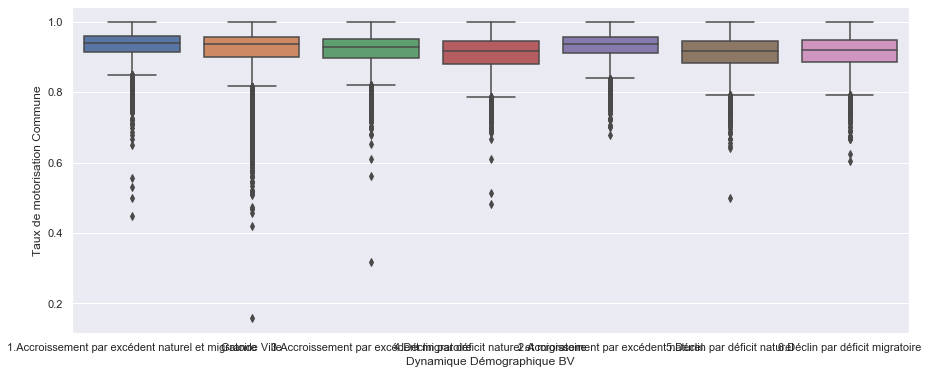

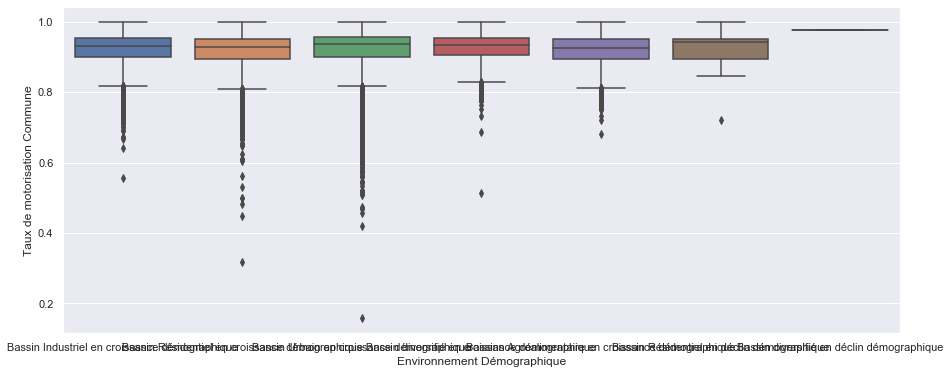

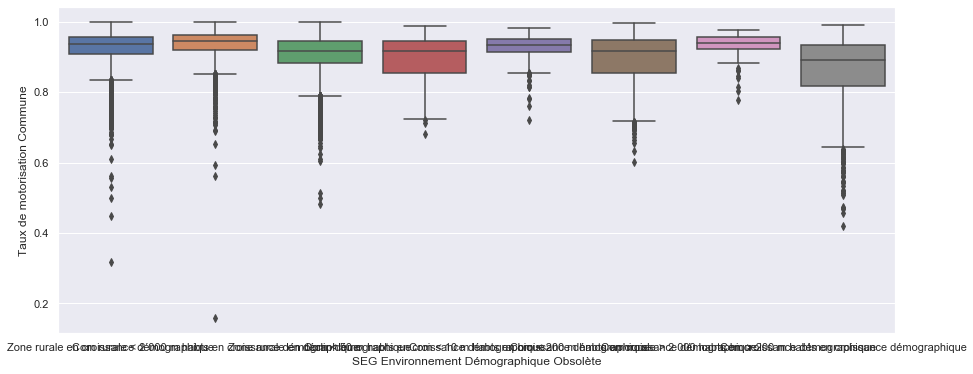

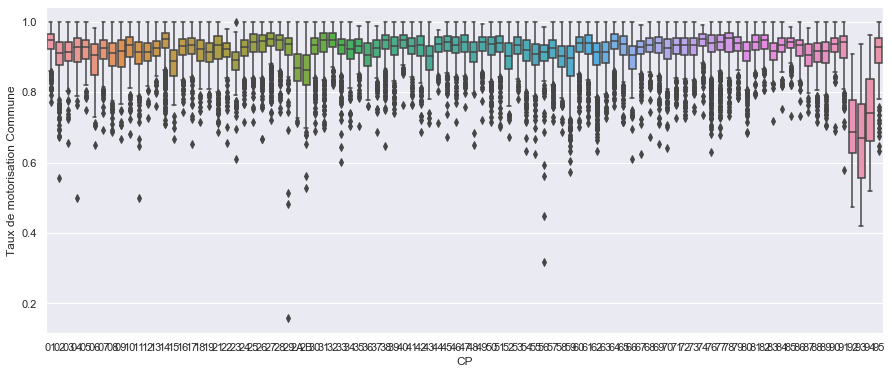

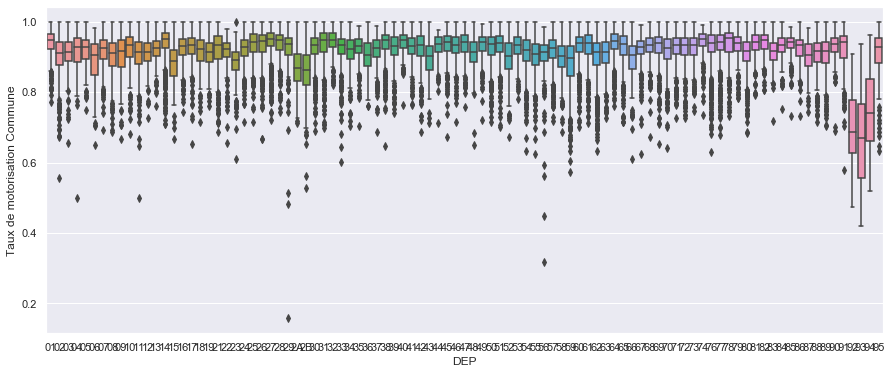

In [223]:
for cat_feat in categorical_features:
    plt.figure(figsize=(15,6))
    sns.boxplot(x=cat_feat, y=target, data=data_set_update_1)

> **Observation 1**: some features seems to separate target value better than others. We can point : 'Fidélité', 'DYN SetC', 'Seg Dyn Entre'

> **Observation 2**: It seems like 'CP' is the same columns as 'DEP'. Let see if there are not other duplicate columns

In [223]:
def getDuplicateColumns(df):
    '''
    Get a list of duplicate columns.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
 
    return list(duplicateColumnNames)

In [224]:
getDuplicateColumns(data_set_no_duplicates)

['CP']

> There is only one duplicate column: CP - DEP

In [379]:
data_set_update_1.drop('DEP', axis=1, inplace=True)
categorical_features.remove('DEP')

### Integers features

> Since I have only 13 integer features left, I am going to look at each one of them and decide if it can be considered as a categorical feature or ordinal feature.

In [380]:
categorical_integer_feat = ['REG']
continuous_integer_feat = ['Score équipement de santé BV', 'Nb Industries des biens intermédiaires',
                           'Nb dentistes Libéraux BV', 'Nb Omnipraticiens BV', 'Nb Infirmiers Libéraux BV',
                           'Evolution Pop %', 'Moyenne Revenus Fiscaux Départementaux',
                           'Taux Propriété', 'Capacité Fisc', 'Synergie Médicale COMMUNE',
                           'Nb Résidences Secondaires', 'Evolution Population']

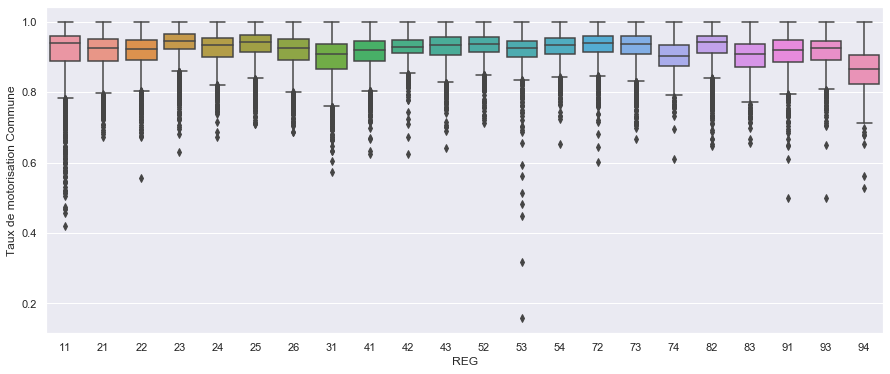

In [282]:
plt.figure(figsize=(15,6))
sns.boxplot(x='REG', y=target, data=data_set_update_1)

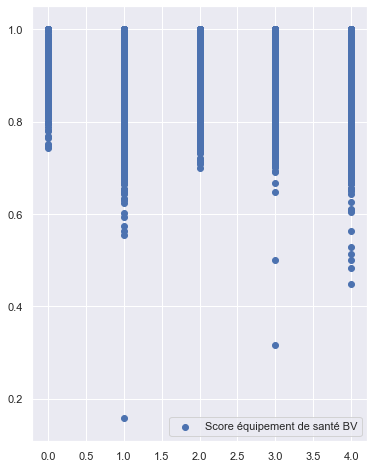

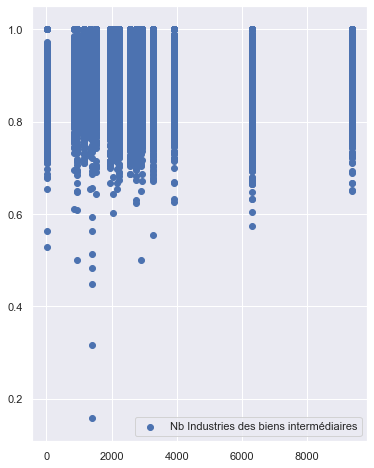

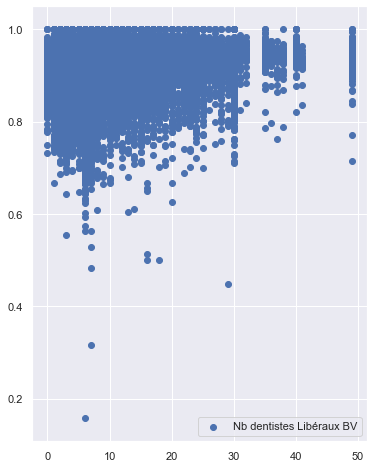

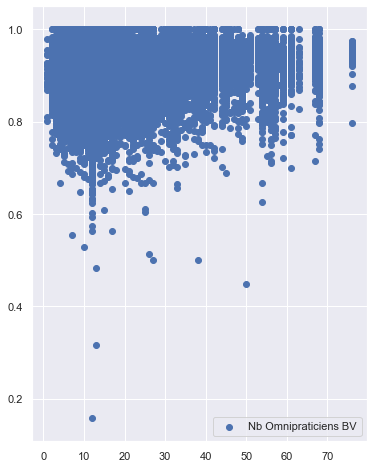

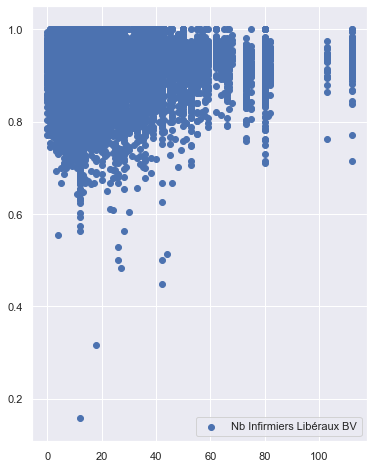

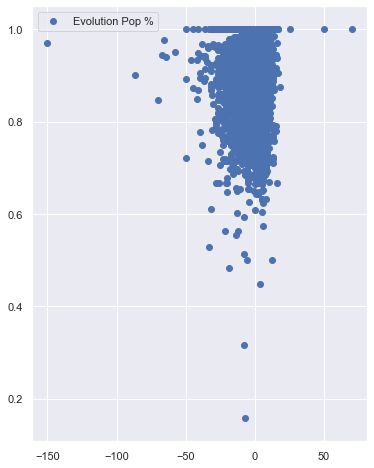

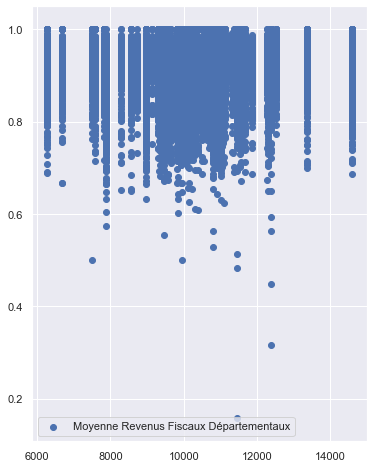

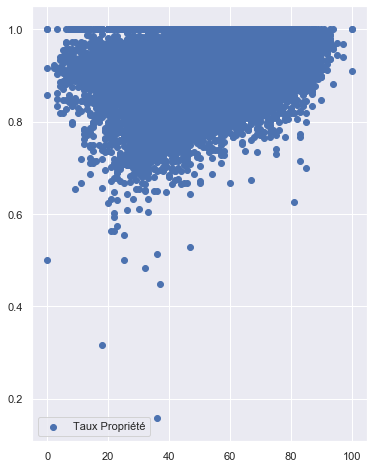

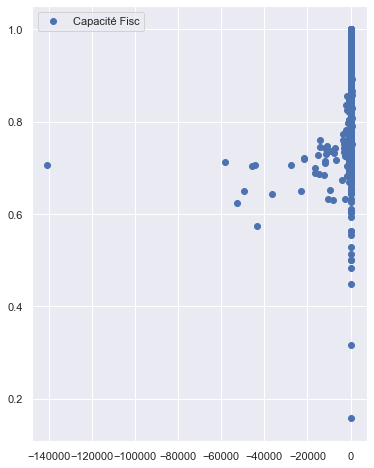

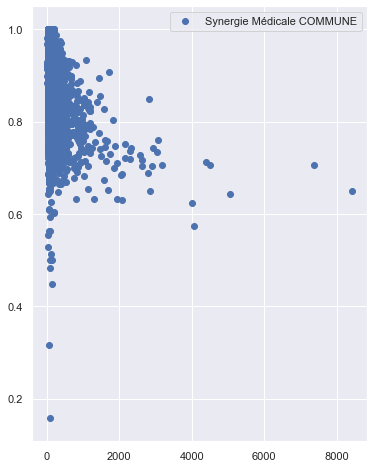

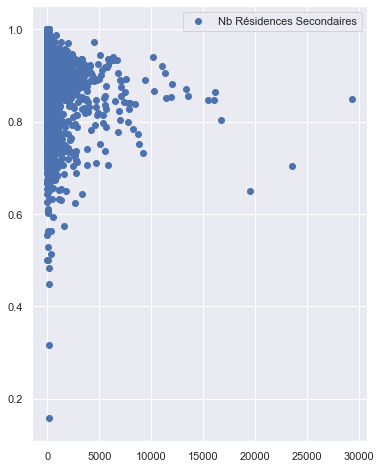

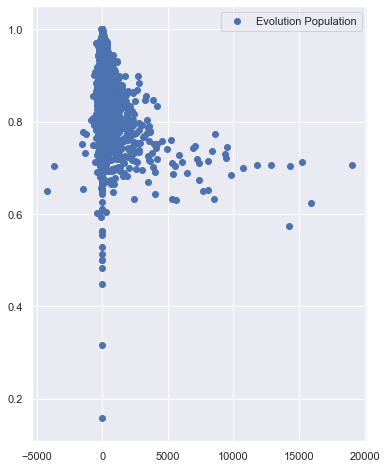

In [240]:
for cont_feat in continuous_integer_feat:
    plt.figure(figsize=(6,8))
    data_without_outlier = data_set_update_1[~data_set_update_1['CODGEO'].isin(rich_codgeo)]
    plt.scatter(data_without_outlier[cont_feat], data_without_outlier[target], label=cont_feat)
    plt.legend()

# TODO Comment 

In [381]:
# Keep only two types of features
categorical_features += categorical_integer_feat
continuous_features += continuous_integer_feat

# Model

In [284]:
overview_features(data_set_update_1)

Nulls  Nulls (%)     Type  \
Feat                                                                          
SEG Croissance POP                                    0        0.0   object   
Fidélité                                              0        0.0   object   
DYN SetC                                              0        0.0   object   
Seg Dyn Entre                                         0        0.0   object   
Seg Cap Fiscale                                       0        0.0   object   
SYN MEDICAL                                           0        0.0   object   
Orientation Economique                                0        0.0   object   
Score équipement de santé BV                          0        0.0    int64   
Urbanité Ruralité                                     0        0.0   object   
Environnement Démographique                           0        0.0   object   
Dynamique Démographique BV                            0        0.0   object   
SEG Environnement Démographique Obsolète              0        0.0   object   
Score Urbanité                                        0        0.0  float64   
Nb Pharmacies et parfumerie                           0        0.0  float64   
Reg Moyenne Salaires Cadre Horaires                   0        0.0  float64   
Valeur ajoutée régionale                              0        0.0  float64   
Reg Moyenne Salaires Ouvrié Horaires                  0        0.0  float64   
Reg Moyenne Salaires Employé Horaires                 0        0.0  float64   
Reg Moyenne Salaires Prof Intermédiaire Horaires      0        0.0  float64   
Nb Industries des biens intermédiaires                0        0.0    int64   
Reg Moyenne Salaires Horaires                         0        0.0  float64   
Indice Fiscal Partiel                                 0        0.0  float64   
REG                                                   0        0.0    int64   
Nb Camping                                            0        0.0  float64   
Nb dentistes Libéraux BV                              0        0.0    int64   
Nb Création Industrielles                             0        0.0  float64   
Nb Hotel                                              0        0.0  float64   
Nb Omnipraticiens BV                                  0        0.0    int64   
Nb Infirmiers Libéraux BV                             0        0.0    int64   
Evolution Pop %                                       0        0.0    int64   
Indice Evasion Client                                 0        0.0  float64   
Dep Moyenne Salaires Ouvrié Horaires                  0        0.0  float64   
Dep Moyenne Salaires Prof Intermédiaire Horaires      0        0.0  float64   
Dep Moyenne Salaires Employé Horaires                 0        0.0  float64   
Moyenne Revnus fiscaux                                0        0.0  float64   
Dep Moyenne Salaires Cadre Horaires                   0        0.0  float64   
CP                                                    0        0.0   object   
Moyenne Revenus Fiscaux Départementaux                0        0.0    int64   
Dep Moyenne Salaires Horaires                         0        0.0  float64   
Taux Propriété                                        0        0.0    int64   
Nb Entreprises Secteur Construction                   0        0.0  float64   
Densité Médicale BV                                   0        0.0  float64   
Capacité Fisc                                         0        0.0    int64   
Capacité Hotel                                        0        0.0  float64   
Capacité Camping                                      0        0.0  float64   
Synergie Médicale COMMUNE                             0        0.0    int64   
Nb Résidences Secondaires                             0        0.0    int64   
Dynamique Entrepreneuriale                            0        0.0  float64   
Evolution Population                                  0        0.0    int64   
Taux de motorisation 

> The categorical features seems to have low cardinality. We are going to proceed to a one hot encoding 

In [425]:
y = data_set_update_1[['Taux de motorisation Commune']]
X = data_set_update_1.drop(['CODGEO', 'Taux de motorisation Commune'], axis=1)

#### Split train/val

In [426]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

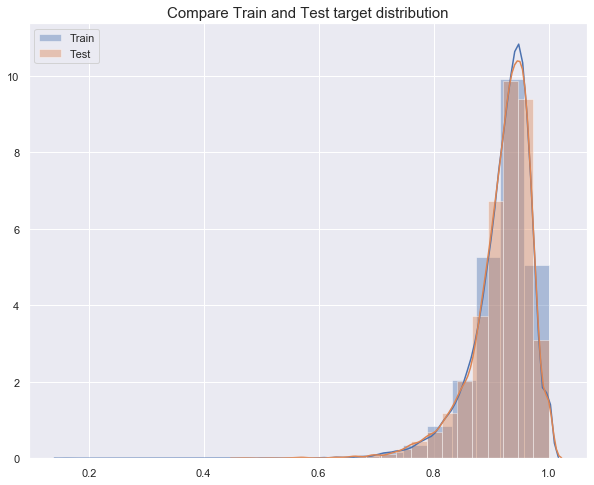

In [427]:
plt.figure(figsize=(10,8))
sns.distplot(y_train.values, bins=20, label='Train')
sns.distplot(y_test.values, bins=20, label='Test')
plt.title('Compare Train and Test target distribution', fontsize=15)
plt.legend(loc='upper left')

> The distributions are similar, we can use these dataset to train and evaluate our models. (There are still some outliers in train around 0.2, but since the number of these observations is very low I decide to keep theml all for now)

#### Preprocess categorical features

In [ ]:
# One hot encode categorical features 
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

def fit_transform(df, istrain, fitter):
    
    if istrain:
        fitter.fit(df)
        
    df_transformed = fitter.transform(df)
    
    return df_transformed

# Train
one_hot_X_train = X_train[categorical_features]

one_hot_X_train = pd.DataFrame(fit_transform(one_hot_X_train, True, one_hot_encoder))
one_hot_X_train.set_axis(one_hot_encoder.get_feature_names(list(X_train[categorical_features].columns)),
                                                           axis=1, inplace=True)
X_train.drop(categorical_features, axis=1, inplace=True)

X_train = pd.concat([X_train, one_hot_X_train], axis=1, sort=False)


# Test
one_hot_X_test = X_test[categorical_features]
one_hot_X_test = pd.DataFrame(fit_transform(one_hot_X_test, False, one_hot_encoder))
one_hot_X_test.set_axis(one_hot_encoder.get_feature_names(list(X_test[categorical_features].columns)),
                                                           axis=1, inplace=True)
X_test.drop(categorical_features, axis=1, inplace=True)

X_test = pd.concat([X_test, one_hot_X_test], axis=1, sort=False)


In [430]:
# Remove unrecognized caracters
def replace_unkwnown_caracters(x):
    x = x.replace('>', 'SUP')
    x = x.replace('<', 'INF')

    return x

X_train.rename(columns={col: replace_unkwnown_caracters(col) for col in X_train.columns}, inplace=True)
X_test.rename(columns={col: replace_unkwnown_caracters(col) for col in X_test.columns}, inplace=True)

In [432]:
X_train.head(1)

Nb Pharmacies et parfumerie  Dynamique Entrepreneuriale  \
0                          0.0                        82.0   

   Synergie Médicale COMMUNE  Indice Fiscal Partiel  Indice Evasion Client  \
0                         89               90.28084                    0.0   

   Nb Omnipraticiens BV  Nb Infirmiers Libéraux BV  Nb dentistes Libéraux BV  \
0                    13                          7                         4   

   Densité Médicale BV  Score équipement de santé BV  Evolution Population  \
0             0.153201                             4                    31   

   Evolution Pop %  Nb Résidences Secondaires  \
0                4                        165   

   Nb Entreprises Secteur Construction  Nb Création Industrielles  \
0                                 11.0                        0.0   

   Moyenne Revenus Fiscaux Départementaux  Dep Moyenne Salaires Horaires  \
0                                    7491                           11.0   

   Dep Moyenne Salaires Cadre Horaires  \
0                            20.607143   

   Dep Moyenne Salaires Prof Intermédiaire Horaires  \
0                                             12.55   

   Dep Moyenne Salaires Employé Horaires  \
0                               8.514286   

   Dep Moyenne Salaires Ouvrié Horaires  Reg Moyenne Salaires Horaires  \
0                              9.207143                      11.814865   

   Reg Moyenne Salaires Cadre Horaires  \
0                            21.835135   

   Reg Moyenne Salaires Prof Intermédiaire Horaires  \
0                                         12.773311   

   Reg Moyenne Salaires Employé Horaires  \
0                               8.660473   

   Reg Moyenne Salaires Ouvrié Horaires  Valeur ajoutée régionale  \
0                              9.207095              62711.263769   

   Score Urbanité  Nb Hotel  Capacité Hotel  Nb Camping  Capacité Camping  \
0            12.5       0.0             0.0         0.0               0.0   

   Taux Propriété  Capacité Fisc  Moyenne Revnus fiscaux  \
0              36             93                  8376.5   

   Nb Industries des biens intermédiaires  \
0                                    2892   

   SEG Croissance POP_en croissance démographique  \
0                                             1.0   

   SEG Croissance POP_en déclin démographique  Fidélité_Pop Mobile  \
0                                         0.0                  0.0   

   Fidélité_Pop Sédentaire  DYN SetC_Bonne Dynamique Entreprise Serv et Com  \
0                      1.0                                              0.0   

   DYN SetC_Dynamique Serv et Com  DYN SetC_Faible Dynamique Serv et Com  \
0                             0.0                                    1.0   

   Seg Dyn Entre_Dynamique Economique  Seg Dyn Entre_Faible dynamique  \
0                                 0.0                             1.0   

   Seg Dyn Entre_Moyenne dynamique  Seg Cap Fiscale_Fiscalité faible  \
0                              0.0                               0.0   

   Seg Cap Fiscale_Fiscalité moyenne  Seg Cap Fiscale_Fiscalité élevée  \
0                                1.0                               0.0   

   SYN MEDICAL_Faible Synergie Médicale  SYN MEDICAL_Forte Synergie Médicale  \
0                                   1.0                                  0.0   

   SYN MEDICAL_Synergie Médicale  Orientation Economique_Bassin Industriel  \
0                            0.0                                       0.0   

   Orientation Economique_Bassin Résidentiel  \
0                                        1.0   

   Orientation Economique_Bassin Urbain  \
0                                   0.0   

   Orientation Economique_Bassin diversifié  \
0                                       0.0   

   Orientation Economique_Bassins Agroalimentaire  \
0                                             0.0   

   Urbanité Ruralité_Com INF 10 m habts  \
0                                   1.0

## Benchmark

#### Metric value

In [502]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true.ravel() - y_pred) / y_true)) * 100

In [437]:
models = [
        RandomForestRegressor(n_jobs=-1),
        LinearRegression(),
        Lasso(),
        XGBRegressor(n_thread=-1)
]

In [438]:
for model in models:
    cv_results = cross_validate(model, X_train, y_train, cv=3, scoring=('r2', 'neg_mean_squared_error'))
    print(type(model).__name__, np.sqrt(np.abs(cv_results['test_neg_mean_squared_error'])))

/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/model_selection/_vali

RandomForestRegressor [0.03739482 0.0377596  0.03874017]
LinearRegression [0.56486981 0.03965124 0.0393232 ]
Lasso [0.04736736 0.0484978  0.04846086]
[11:35:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:35:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:35:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor [0.03549161 0.03689806 0.03683014]


In [ ]:
mean_absolute_percentage_error(y_test, y_pred)

> We can see that XGBRegressor performs best.

Let see what are the most important features according to the model

### Random forest regressor - GridSearch

In [504]:
y_test

Taux de motorisation Commune
33732                      0.944915
20947                      0.857143
12558                      0.950000
11390                      0.821429
34739                      0.959854
...                             ...
5047                       0.977778
12122                      0.918919
9102                       0.945946
23681                      0.923810
22173                      0.921569

[7299 rows x 1 columns]

In [505]:
rf_reg = RandomForestRegressor(random_state=42, n_jobs=-1)

from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n') 
pprint(rf_reg.get_params())

rf_reg.fit(X_train, y_train)
rf_y_pred = rf_reg.predict(X_test)

print('MAPE basic RandomForestRegressor: {} %'.format(mean_absolute_percentage_error(y_test['Taux de motorisation Commune'],
                                                                                   rf_y_pred)))

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


MAPE basic RandomForestRegressor: 2.9788449111844093


> Predictions have an error of 3% compared to true values, which is in my opinion a good start

In [335]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'n_estimators': [80, 100, 200Then]
}

# Create a based model
rf_reg = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf_reg, param_grid = param_grid, 
                          cv=3, n_jobs=-1, verbose=2)


In [336]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 4 folds for each of 288 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 33.6min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 51.7min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed: 59.3min finished
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 200}

In [443]:
best_grid = grid_search.best_estimator_
rf_grid_y_pred = best_grid.predict(X_test)
print('MAPE GridSearch RandomForestRegressor: {} %'.format(mean_absolute_percentage_error(y_test['Taux de motorisation Commune'], 
                                                                                                          rf_grid_y_pred)))

RMSE GridSearch RandomForestRegressor: 0.03981338597864066


### Feature importance Random Forest model

In [353]:
feature_importances = pd.DataFrame(grid_search.best_estimator_.feature_importances_, index = X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

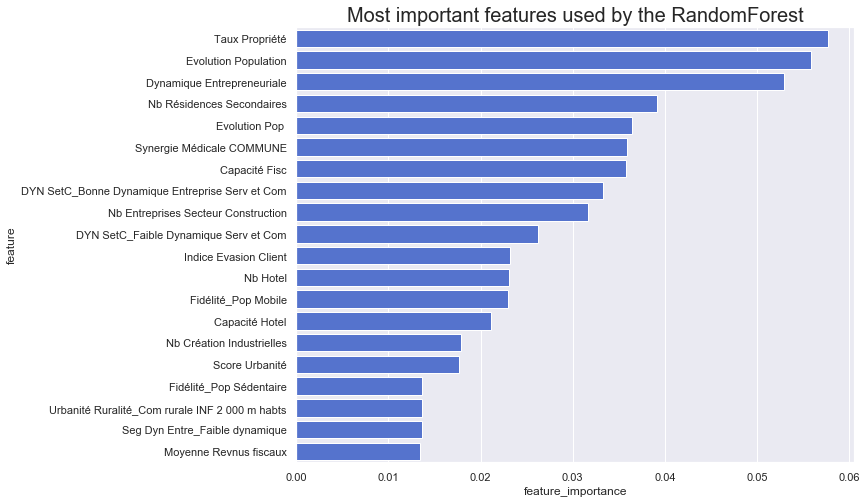

In [447]:
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)
    return imp_df.feature
    
plt.figure(figsize=(10,8))   
most_important_features_rf = var_imp_plot(feature_importances.reset_index().iloc[:20, :], 'Most important features used by the RandomForest')


### Recursive feature elimination

In [455]:
most_important_features_rf = most_important_features_rf.replace('Evolution Pop ', 'Evolution Pop %')

In [482]:
X_train_new = X_train[list(most_important_features_rf[:10].values)].reset_index(drop=True)
X_test_new = X_test[list(most_important_features_rf[:10].values)].reset_index(drop=True)

In [483]:
X_train.head(1)

Nb Pharmacies et parfumerie  Dynamique Entrepreneuriale  \
0                          0.0                        82.0   

   Synergie Médicale COMMUNE  Indice Fiscal Partiel  Indice Evasion Client  \
0                         89               90.28084                    0.0   

   Nb Omnipraticiens BV  Nb Infirmiers Libéraux BV  Nb dentistes Libéraux BV  \
0                    13                          7                         4   

   Densité Médicale BV  Score équipement de santé BV  Evolution Population  \
0             0.153201                             4                    31   

   Evolution Pop %  Nb Résidences Secondaires  \
0                4                        165   

   Nb Entreprises Secteur Construction  Nb Création Industrielles  \
0                                 11.0                        0.0   

   Moyenne Revenus Fiscaux Départementaux  Dep Moyenne Salaires Horaires  \
0                                    7491                           11.0   

   Dep Moyenne Salaires Cadre Horaires  \
0                            20.607143   

   Dep Moyenne Salaires Prof Intermédiaire Horaires  \
0                                             12.55   

   Dep Moyenne Salaires Employé Horaires  \
0                               8.514286   

   Dep Moyenne Salaires Ouvrié Horaires  Reg Moyenne Salaires Horaires  \
0                              9.207143                      11.814865   

   Reg Moyenne Salaires Cadre Horaires  \
0                            21.835135   

   Reg Moyenne Salaires Prof Intermédiaire Horaires  \
0                                         12.773311   

   Reg Moyenne Salaires Employé Horaires  \
0                               8.660473   

   Reg Moyenne Salaires Ouvrié Horaires  Valeur ajoutée régionale  \
0                              9.207095              62711.263769   

   Score Urbanité  Nb Hotel  Capacité Hotel  Nb Camping  Capacité Camping  \
0            12.5       0.0             0.0         0.0               0.0   

   Taux Propriété  Capacité Fisc  Moyenne Revnus fiscaux  \
0              36             93                  8376.5   

   Nb Industries des biens intermédiaires  \
0                                    2892   

   SEG Croissance POP_en croissance démographique  \
0                                             1.0   

   SEG Croissance POP_en déclin démographique  Fidélité_Pop Mobile  \
0                                         0.0                  0.0   

   Fidélité_Pop Sédentaire  DYN SetC_Bonne Dynamique Entreprise Serv et Com  \
0                      1.0                                              0.0   

   DYN SetC_Dynamique Serv et Com  DYN SetC_Faible Dynamique Serv et Com  \
0                             0.0                                    1.0   

   Seg Dyn Entre_Dynamique Economique  Seg Dyn Entre_Faible dynamique  \
0                                 0.0                             1.0   

   Seg Dyn Entre_Moyenne dynamique  Seg Cap Fiscale_Fiscalité faible  \
0                              0.0                               0.0   

   Seg Cap Fiscale_Fiscalité moyenne  Seg Cap Fiscale_Fiscalité élevée  \
0                                1.0                               0.0   

   SYN MEDICAL_Faible Synergie Médicale  SYN MEDICAL_Forte Synergie Médicale  \
0                                   1.0                                  0.0   

   SYN MEDICAL_Synergie Médicale  Orientation Economique_Bassin Industriel  \
0                            0.0                                       0.0   

   Orientation Economique_Bassin Résidentiel  \
0                                        1.0   

   Orientation Economique_Bassin Urbain  \
0                                   0.0   

   Orientation Economique_Bassin diversifié  \
0                                       0.0   

   Orientation Economique_Bassins Agroalimentaire  \
0                                             0.0   

   Urbanité Ruralité_Com INF 10 m habts  \
0                                   1.0

In [485]:
from sklearn.feature_selection import RFECV

rfecv = RFECV(XGBRegressor(), cv=3, scoring='neg_mean_squared_error')

rfecv.fit(X_train_new, y_train)        # Fit the data to the visualizer


/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[14:14:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:14:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:14:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:14:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:14:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:14:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:14:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:14:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:14:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

RFECV(cv=3,
      estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                             colsample_bylevel=1, colsample_bynode=1,
                             colsample_bytree=1, gamma=0,
                             importance_type='gain', learning_rate=0.1,
                             max_delta_step=0, max_depth=3, min_child_weight=1,
                             missing=None, n_estimators=100, n_jobs=1,
                             nthread=None, objective='reg:linear',
                             random_state=0, reg_alpha=0, reg_lambda=1,
                             scale_pos_weight=1, seed=None, silent=None,
                             subsample=1, verbosity=1),
      min_features_to_select=1, n_jobs=None, scoring='neg_mean_squared_error',
      step=1, verbose=0)

In [490]:
def var_imp_plot_2(imp_df, title, label=None):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue', label=label) \
       .set_title(title, fontsize = 20)
    plt.legend(fontsize=15, loc='lower right')
    return imp_df.feature

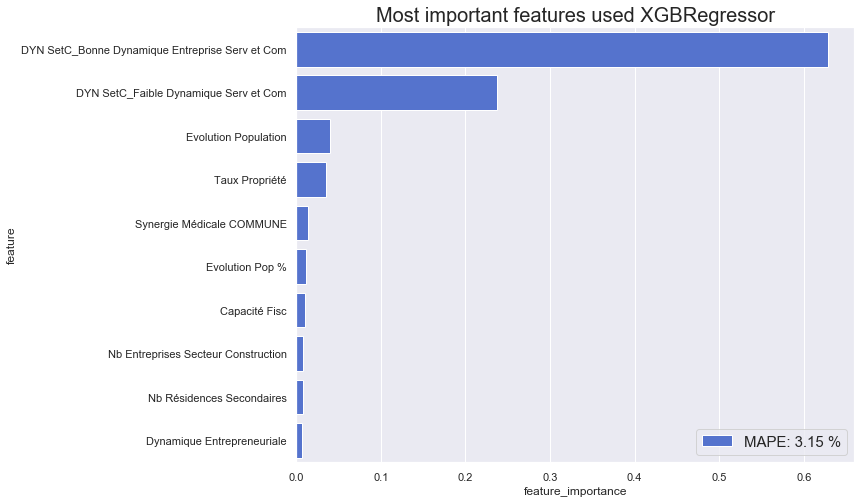

In [506]:
feature_importances_xgb = pd.DataFrame(rfecv.estimator_.feature_importances_, index = data_set_update_2.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

y_pred_xgb = rfecv.predict(X_test_new)

plt.figure(figsize=(10, 8))
label_xgb_regressor = round(mean_absolute_percentage_error(y_test['Taux de motorisation Commune'], y_pred_xgb), 3)
_ = var_imp_plot_2(feature_importances_xgb.reset_index(), 'Most important features used XGBRegressor', 
                   label='MAPE: {} %'.format(str(label_xgb_regressor)))